<a href="https://colab.research.google.com/github/Hbnyoni/CHEAQI-Dynamic-Indicators/blob/main/Mozambique_NDVI_Dynamic_Indicators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install geehydro
!pip install rioxarray
!apt install gdal-bin python3-gdal
!pip install fiona
!pip install rasterio
!pip install geopandas
!pip install folium
!pip install geemap
!pip install cartopy
!pip install mapclassify
!pip install geoplot
!pip install pyreadr
!pip install pysal

  Preparing metadata (setup.py) ... done
  Created wheel for geehydro: filename=geehydro-0.2.0-py2.py3-none-any.whl size=10124 sha256=5c4b52914a0b9e34483dba0f279f7cff7847f85b989f351426ce29e6a1eaca3a
  Stored in directory: /root/.cache/pip/wheels/90/ad/c9/ab38b841cd7f4dc8070c1ceb90810f6b7228daa3a4081f4880
Successfully built geehydro
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 35.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  libgdal-grass python-numpy-doc python3-pytest
The following NEW packages will be installed:
  gdal-bin python3-gdal python3-numpy
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 5,055 kB of archives.
After this operation, 25.1 MB of additional disk space will be used.
Get:1 http://archive.ubu

In [5]:
#import all libraries
import folium, cartopy, mapclassify
import os
import geopandas as gpd
import numpy as np, pandas as pd
import ee
import geemap
from datetime import datetime
import geopandas as gpd
import requests
from io import BytesIO
import pyreadr
import time
import concurrent.futures
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Authenticate and initialize Earth Engine API
try:
    ee.Initialize(project='ee-cheaqi')
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [ ]:
# Check if notebook is running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
   IN_COLAB = False

In [ ]:
if IN_COLAB:
    # Use the token from Github to clone the PRECISE repository with read/write access
    from IPython.display import clear_output; user="Hbnyoni"; token=input();
    !git clone https://github.com/Hbnyoni/dynamic_indicators.git

    clear_output()

  district      admin_post      locality         name  neighborhood_code  \
0  MANHIÇA  3 DE FEVEREIRO       Taninga    4º Bairro             258018   
1  MANHIÇA         MALUANA  Maluana_sede       Pafene             258115   
2   MAGUDE          MAGUDE      CHICHUCO      Chicuco             258058   
3   MAGUDE          MAGUDE      MATCHABE  Bairro 2000             258031   
4   MAGUDE          MAGUDE    MAGUIGUANE      Bangane             258048   

                                            geometry  
0  MULTIPOLYGON (((32.84430 -25.16290, 32.84846 -...  
1  MULTIPOLYGON (((32.65184 -25.54759, 32.65305 -...  
2  MULTIPOLYGON (((32.64127 -25.11344, 32.64141 -...  
3  MULTIPOLYGON (((32.67021 -25.01076, 32.66487 -...  
4  MULTIPOLYGON (((32.73317 -24.90993, 32.72411 -...  


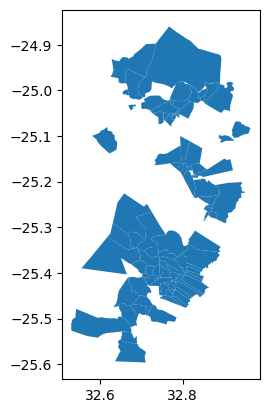

In [ ]:
##load shapefile form github
# GitHub raw URL for the GeoPackage
url = 'https://github.com/Hbnyoni/dynamic_indicators/raw/main/shapefiles1/precise_villages.gpkg'

# Download the file using requests
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Read the file using geopandas from the bytes content
    with BytesIO(response.content) as f:
        gdf = gpd.read_file(f, layer='Mozambique')

    # Plot the geodataframe
    gdf.plot()
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

# Print the attribute table
print(gdf.head())

In [ ]:
#Function to get the image propeties sentinel 2A images in the study time period
# Initialize the Earth Engine API
ee.Initialize()
# Define the region of interest (ROI)
roi = ee.Geometry.Rectangle([32.0, -26.0, 33.0, -24.0])

# Fetch the first image from the Sentinel-2 ImageCollection for inspection
image_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterDate('2022-01-01', '2023-01-31') \
    .filterBounds(roi) \
    .first()

# Get the image properties
image_properties = image_collection.toDictionary().getInfo()

# Print the image properties
print(image_properties)

{'AOT_RETRIEVAL_ACCURACY': 0, 'CLOUDY_PIXEL_PERCENTAGE': 83.177271, 'CLOUD_COVERAGE_ASSESSMENT': 83.177271, 'CLOUD_SHADOW_PERCENTAGE': 0.168981, 'DARK_FEATURES_PERCENTAGE': 0.03634, 'DATASTRIP_ID': 'S2A_OPER_MSI_L2A_DS_VGS1_20220103T102101_S20220103T080140_N03.01', 'DATATAKE_IDENTIFIER': 'GS2A_20220103T074321_034123_N03.01', 'DATATAKE_TYPE': 'INS-NOBS', 'DEGRADED_MSI_DATA_PERCENTAGE': 0, 'FORMAT_CORRECTNESS': 'PASSED', 'GENERAL_QUALITY': 'PASSED', 'GENERATION_TIME': 1641205261000, 'GEOMETRIC_QUALITY': 'PASSED', 'GRANULE_ID': 'L2A_T36JUS_A034123_20220103T080140', 'HIGH_PROBA_CLOUDS_PERCENTAGE': 76.761496, 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B1': 177.17986720434, 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B10': 178.638719559933, 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B11': 177.260540469243, 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B12': 176.845073439667, 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B2': 181.751253788159, 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B3': 179.545694904482, 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B4': 178.375492290793, 'MEAN_INCIDENCE

In [ ]:
# Function to fetch available image dates
def get_image_dates(start_date, end_date, roi):
    # Create the Sentinel-2 image collection
    collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                  .filterDate(start_date, end_date)
                  .filterBounds(roi)
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

    # Extract the dates from the collection
    image_dates = collection.aggregate_array('system:time_start').getInfo()
    dates_list = [ee.Date(date).format('YYYY-MM-dd').getInfo() for date in image_dates]

    return dates_list

# Define the date range
start_date = '2022-01-01'
end_date = '2023-01-31'

# Get the list of available image dates in the region of interest (roi)
available_dates = get_image_dates(start_date, end_date, roi)

# Print the available dates
print("Available Sentinel-2 image dates in the region of interest:")
print(available_dates)


Available Sentinel-2 image dates in the region of interest:
['2022-01-05', '2022-01-05', '2022-01-10', '2022-01-10', '2022-01-15', '2022-01-15', '2022-01-18', '2022-01-18', '2022-01-20', '2022-02-02', '2022-02-02', '2022-02-09', '2022-02-09', '2022-02-09', '2022-02-09', '2022-02-09', '2022-02-09', '2022-02-12', '2022-02-12', '2022-02-14', '2022-02-19', '2022-02-19', '2022-02-19', '2022-02-19', '2022-02-19', '2022-02-19', '2022-02-19', '2022-02-24', '2022-02-24', '2022-03-04', '2022-03-06', '2022-03-11', '2022-03-14', '2022-03-14', '2022-03-14', '2022-03-14', '2022-03-14', '2022-03-14', '2022-03-14', '2022-03-14', '2022-03-19', '2022-03-21', '2022-03-24', '2022-03-24', '2022-03-24', '2022-03-24', '2022-03-24', '2022-03-24', '2022-03-24', '2022-03-24', '2022-03-24', '2022-03-29', '2022-03-29', '2022-03-29', '2022-03-29', '2022-03-29', '2022-03-29', '2022-03-31', '2022-03-31', '2022-03-31', '2022-03-31', '2022-03-31', '2022-03-31', '2022-04-03', '2022-04-03', '2022-04-03', '2022-04-03', '

In [ ]:
##Filtering Outdoor exposure  datapoints that have same dates with the available sentinel images
# Define the path to the RDS file
input_rds_path = '/content/dynamic_indicators/outdoor_data_Mozambique.rds'  # Replace with the actual RDS file path

# Define the list of dates to filter (based on the provided available dates)
filter_dates = [
    '2022-01-05', '2022-01-05', '2022-01-10', '2022-01-18', '2022-02-02', '2022-02-09', '2022-02-09', '2022-02-19',
    '2022-02-19', '2022-02-19', '2022-02-24', '2022-03-14', '2022-03-14', '2022-03-21', '2022-03-24', '2022-03-24',
    '2022-03-29', '2022-03-29', '2022-03-31', '2022-03-31', '2022-04-03', '2022-04-03', '2022-04-05', '2022-04-05',
    '2022-04-05', '2022-04-13', '2022-04-23', '2022-04-25', '2022-04-28', '2022-04-28', '2022-04-30', '2022-04-30',
    '2022-05-03', '2022-05-10', '2022-05-10', '2022-05-13', '2022-05-13', '2022-05-20', '2022-05-20', '2022-05-25',
    '2022-05-25', '2022-06-02', '2022-06-02', '2022-06-04', '2022-06-04', '2022-06-07', '2022-06-07', '2022-06-09',
    '2022-06-09', '2022-06-12', '2022-06-12', '2022-06-14', '2022-06-14', '2022-06-17', '2022-06-17', '2022-06-19',
    '2022-06-19', '2022-06-24', '2022-06-24', '2022-06-29', '2022-06-29', '2022-07-02', '2022-07-02', '2022-07-04',
    '2022-07-04', '2022-07-07', '2022-07-07', '2022-07-09', '2022-07-14', '2022-07-14', '2022-07-17', '2022-07-24',
    '2022-07-27', '2022-07-27', '2022-07-29', '2022-07-29', '2022-08-06', '2022-08-08', '2022-08-08', '2022-08-11',
    '2022-08-11', '2022-08-16', '2022-08-16', '2022-08-18', '2022-08-18', '2022-08-21', '2022-08-23', '2022-08-26',
    '2022-08-26', '2022-08-31', '2022-08-31', '2022-09-02', '2022-09-02', '2022-09-05', '2022-09-05', '2022-09-10',
    '2022-09-10', '2022-09-15', '2022-09-15', '2022-09-17', '2022-09-17', '2022-09-25', '2022-09-25', '2022-09-30',
    '2022-09-30', '2022-11-21', '2022-11-24', '2022-12-24', '2022-12-24', '2023-01-03', '2023-01-03', '2023-01-10',
    '2023-01-10', '2023-01-15', '2023-01-25', '2023-01-28', '2023-01-28'
]

# Convert the list of dates to datetime objects for comparison (with just the date part)
filter_dates = pd.to_datetime(filter_dates, format='%Y-%m-%d')

# Read the RDS file using pyreadr
result = pyreadr.read_r(input_rds_path)
df = result[None]  # Extract the DataFrame

# Convert the 'date' column to datetime format (including time)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Extract the date part from the 'date' column for comparison
df['date_only'] = df['date'].dt.normalize()

# Filter the DataFrame to keep only rows with dates in the filter_dates list
filtered_df = df[df['date_only'].isin(filter_dates)]

# Output the filtered data (e.g., save to a new CSV file or print to console)
output_csv_path = '/content/dynamic_indicators/Mozambique_filtered_dates.csv'
filtered_df.to_csv(output_csv_path, index=False)

print(f"Filtered data saved to {output_csv_path}")


Filtered data saved to /content/dynamic_indicators/Mozambique_filtered_dates.csv


In [ ]:
##generate NDVI rasters for each date and Assign NDVI values to the filtered data points using corresponding location and date
# Initialize the Earth Engine API
ee.Initialize()

# Load the filtered dataset
filtered_data_path = '/content/dynamic_indicators/Mozambique_filtered_dates.csv'
filtered_data = pd.read_csv(filtered_data_path)

# Convert 'date_only' column to datetime format for comparison
filtered_data['date_only'] = pd.to_datetime(filtered_data['date_only'], format='%Y-%m-%d')

# Define a cloud masking function for Sentinel-2 images
def mask_s2_clouds(image):
    qa = image.select('QA60')
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    return image.updateMask(mask).divide(10000)

# Function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Define the region of interest (bounding box or shapefile from previous code)
roi = ee.Geometry.Rectangle([32.0, -26.0, 33.0, -24.0])  # Example, replace with actual ROI

# List to store NDVI values for each row in the filtered data
ndvi_values = []

# Batch size
batch_size = 500

# Save results in batches to avoid losing progress
def process_batch(batch, batch_num):
    ndvi_values_batch = []

    for index, row in batch.iterrows():
        lat = row['lat']
        lon = row['lon']
        date_str = row['date_only'].strftime('%Y-%m-%d')
        ee_date = ee.Date(date_str)

        # Get the Sentinel-2 image collection for the specific date
        image_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                            .filterDate(ee_date, ee_date.advance(1, 'day'))
                            .filterBounds(ee.Geometry.Point(lon, lat))
                            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
                            .map(mask_s2_clouds)
                            .map(calculate_ndvi))

        image = image_collection.first()

        if image:
            point = ee.Geometry.Point([lon, lat])
            ndvi_value = image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=point,
                scale=20  # Lowering the scale to 20m resolution for faster processing
            ).get('NDVI').getInfo()

            ndvi_values_batch.append(ndvi_value)
        else:
            ndvi_values_batch.append(None)

        print(f"Processed point {index + 1}/{len(batch)}: Date {date_str}, Lat {lat}, Lon {lon}, NDVI: {ndvi_value}")

    # Save intermediate results to a CSV file after processing each batch
    batch['NDVI'] = ndvi_values_batch
    batch.to_csv(f'/content/dynamic_indicators/Mozambique_filtered_dates_batch_{batch_num}.csv', index=False)
    print(f"Batch {batch_num} processed and saved.")

# Split data into batches and process
num_batches = len(filtered_data) // batch_size + 1

for i in range(num_batches):
    print(f"Processing batch {i + 1}/{num_batches}")
    batch = filtered_data.iloc[i * batch_size : (i + 1) * batch_size]
    process_batch(batch, i + 1)

# After processing all batches, combine them into a single CSV
combined_data = pd.concat([pd.read_csv(f'/content/dynamic_indicators/Mozambique_filtered_dates_batch_{i + 1}.csv') for i in range(num_batches)])
combined_data.to_csv('/content/dynamic_indicators/Mozambique_filtered_dates_with_ndvi.csv', index=False)

print(f"All batches processed and combined. Final result saved to /content/dynamic_indicators/Mozambique_filtered_dates_with_ndvi.csv")


<ipython-input-32-d245674f0067>:7: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  filtered_data = pd.read_csv(filtered_data_path)


Processing batch 1/252
Processed point 1/500: Date 2022-05-10, Lat -25.05673, Lon 32.79506, NDVI: 0.4185328185328185
Processed point 2/500: Date 2022-05-10, Lat -25.05693, Lon 32.79534, NDVI: 0.4961933134723601
Processed point 3/500: Date 2022-05-10, Lat -25.06436, Lon 32.84427, NDVI: 0.6337314513210279
Processed point 4/500: Date 2022-05-10, Lat -25.06136, Lon 32.84727, NDVI: 0.2839248434237996
Processed point 5/500: Date 2022-05-10, Lat -25.05671, Lon 32.79503, NDVI: 0.4185328185328185
Processed point 6/500: Date 2022-05-10, Lat -25.06437, Lon 32.84425, NDVI: 0.6337314513210279
Processed point 7/500: Date 2022-05-10, Lat -25.06135, Lon 32.84724, NDVI: 0.2839248434237996
Processed point 8/500: Date 2022-05-10, Lat -25.05671, Lon 32.79503, NDVI: 0.4185328185328185
Processed point 9/500: Date 2022-05-10, Lat -25.06439, Lon 32.84426, NDVI: 0.6337314513210279
Processed point 10/500: Date 2022-05-10, Lat -25.06135, Lon 32.84724, NDVI: 0.2839248434237996
Processed point 11/500: Date 2022-05

<ipython-input-32-d245674f0067>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['NDVI'] = ndvi_values_batch


Batch 1 processed and saved.
Processing batch 2/252
Processed point 501/500: Date 2022-05-10, Lat -25.0643, Lon 32.84438, NDVI: 0.5051717004551097
Processed point 502/500: Date 2022-05-10, Lat -25.06134, Lon 32.84726, NDVI: 0.2839248434237996
Processed point 503/500: Date 2022-05-10, Lat -25.06427, Lon 32.84439, NDVI: 0.5051717004551097
Processed point 504/500: Date 2022-05-10, Lat -25.06133, Lon 32.84727, NDVI: 0.2839248434237996
Processed point 505/500: Date 2022-05-10, Lat -25.06428, Lon 32.84439, NDVI: 0.5051717004551097
Processed point 506/500: Date 2022-05-10, Lat -25.06133, Lon 32.84726, NDVI: 0.2839248434237996
Processed point 507/500: Date 2022-05-10, Lat -25.06429, Lon 32.84437, NDVI: 0.5051717004551097
Processed point 508/500: Date 2022-05-10, Lat -25.06133, Lon 32.84726, NDVI: 0.2839248434237996
Processed point 509/500: Date 2022-05-10, Lat -25.06429, Lon 32.84439, NDVI: 0.5051717004551097
Processed point 510/500: Date 2022-05-10, Lat -25.06133, Lon 32.84726, NDVI: 0.283924

<ipython-input-32-d245674f0067>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['NDVI'] = ndvi_values_batch


Processed point 1001/500: Date 2022-05-10, Lat -25.06433, Lon 32.84434, NDVI: 0.5051717004551097
Processed point 1002/500: Date 2022-05-10, Lat -25.0613, Lon 32.84727, NDVI: 0.2839248434237996
Processed point 1003/500: Date 2022-05-10, Lat -25.06431, Lon 32.84433, NDVI: 0.6079891672308734
Processed point 1004/500: Date 2022-05-10, Lat -25.0613, Lon 32.84727, NDVI: 0.2839248434237996
Processed point 1005/500: Date 2022-05-10, Lat -25.06432, Lon 32.84433, NDVI: 0.6079891672308734
Processed point 1006/500: Date 2022-05-10, Lat -25.06133, Lon 32.84728, NDVI: 0.2839248434237996
Processed point 1007/500: Date 2022-05-10, Lat -25.06432, Lon 32.84432, NDVI: 0.6079891672308734
Processed point 1008/500: Date 2022-05-10, Lat -25.06134, Lon 32.84728, NDVI: 0.2839248434237996
Processed point 1009/500: Date 2022-05-10, Lat -25.06433, Lon 32.84432, NDVI: 0.6079891672308734
Processed point 1010/500: Date 2022-05-10, Lat -25.06134, Lon 32.84727, NDVI: 0.2839248434237996
Processed point 1011/500: Date 2

<ipython-input-32-d245674f0067>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['NDVI'] = ndvi_values_batch


Batch 3 processed and saved.
Processing batch 4/252
Processed point 1501/500: Date 2022-05-10, Lat -25.06435, Lon 32.84431, NDVI: 0.6337314513210279
Processed point 1502/500: Date 2022-05-10, Lat -25.06129, Lon 32.84724, NDVI: 0.2839248434237996
Processed point 1503/500: Date 2022-05-10, Lat -25.06435, Lon 32.84431, NDVI: 0.6337314513210279
Processed point 1504/500: Date 2022-05-10, Lat -25.06129, Lon 32.84725, NDVI: 0.2839248434237996
Processed point 1505/500: Date 2022-05-10, Lat -25.06435, Lon 32.84431, NDVI: 0.6337314513210279
Processed point 1506/500: Date 2022-05-10, Lat -25.06129, Lon 32.84725, NDVI: 0.2839248434237996
Processed point 1507/500: Date 2022-05-10, Lat -25.06435, Lon 32.84431, NDVI: 0.6337314513210279
Processed point 1508/500: Date 2022-05-10, Lat -25.0613, Lon 32.84725, NDVI: 0.2839248434237996
Processed point 1509/500: Date 2022-05-10, Lat -25.06435, Lon 32.84431, NDVI: 0.6337314513210279
Processed point 1510/500: Date 2022-05-10, Lat -25.0613, Lon 32.84725, NDVI:

<ipython-input-32-d245674f0067>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['NDVI'] = ndvi_values_batch


Processed point 2001/500: Date 2022-05-20, Lat -25.48825, Lon 32.71369, NDVI: 0.3330017408604825
Processed point 2002/500: Date 2022-05-20, Lat -25.3916, Lon 32.78996, NDVI: 0.464938126104891
Processed point 2003/500: Date 2022-05-20, Lat -25.39951, Lon 32.73487, NDVI: 0.7544483985765124
Processed point 2004/500: Date 2022-05-20, Lat -25.48825, Lon 32.71369, NDVI: 0.3330017408604825
Processed point 2005/500: Date 2022-05-20, Lat -25.39161, Lon 32.78998, NDVI: 0.464938126104891
Processed point 2006/500: Date 2022-05-20, Lat -25.39952, Lon 32.73486, NDVI: 0.7544483985765124
Processed point 2007/500: Date 2022-05-20, Lat -25.48825, Lon 32.71369, NDVI: 0.3330017408604825
Processed point 2008/500: Date 2022-05-20, Lat -25.39161, Lon 32.78998, NDVI: 0.464938126104891
Processed point 2009/500: Date 2022-05-20, Lat -25.39954, Lon 32.73486, NDVI: 0.7544483985765124
Processed point 2010/500: Date 2022-05-20, Lat -25.48825, Lon 32.71369, NDVI: 0.3330017408604825
Processed point 2011/500: Date 202

<ipython-input-32-d245674f0067>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['NDVI'] = ndvi_values_batch


Processed point 2501/500: Date 2022-05-20, Lat -25.39947, Lon 32.73492, NDVI: 0.7544483985765124
Processed point 2502/500: Date 2022-05-20, Lat -25.48823, Lon 32.71369, NDVI: 0.3330017408604825
Processed point 2503/500: Date 2022-05-20, Lat -25.39165, Lon 32.79006, NDVI: 0.29046563192904656
Processed point 2504/500: Date 2022-05-20, Lat -25.39952, Lon 32.73492, NDVI: 0.7544483985765124
Processed point 2505/500: Date 2022-05-20, Lat -25.48823, Lon 32.71369, NDVI: 0.3330017408604825
Processed point 2506/500: Date 2022-05-20, Lat -25.39165, Lon 32.79008, NDVI: 0.29046563192904656
Processed point 2507/500: Date 2022-05-20, Lat -25.39955, Lon 32.73482, NDVI: 0.7544483985765124
Processed point 2508/500: Date 2022-05-20, Lat -25.48824, Lon 32.71369, NDVI: 0.3330017408604825
Processed point 2509/500: Date 2022-05-20, Lat -25.39165, Lon 32.79004, NDVI: 0.29046563192904656
Processed point 2510/500: Date 2022-05-20, Lat -25.39959, Lon 32.73484, NDVI: 0.7813664596273291
Processed point 2511/500: D

<ipython-input-32-d245674f0067>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['NDVI'] = ndvi_values_batch


Processed point 3001/500: Date 2022-05-20, Lat -25.39154, Lon 32.78983, NDVI: 0.5213233393641767
Processed point 3002/500: Date 2022-05-20, Lat -25.39948, Lon 32.73497, NDVI: 0.6023222060957909
Processed point 3003/500: Date 2022-05-20, Lat -25.48823, Lon 32.71372, NDVI: 0.3330017408604825
Processed point 3004/500: Date 2022-05-20, Lat -25.39151, Lon 32.78985, NDVI: 0.4986025712688653
Processed point 3005/500: Date 2022-05-20, Lat -25.39948, Lon 32.73495, NDVI: 0.6023222060957909
Processed point 3006/500: Date 2022-05-20, Lat -25.48824, Lon 32.71373, NDVI: 0.3330017408604825
Processed point 3007/500: Date 2022-05-20, Lat -25.3915, Lon 32.78988, NDVI: 0.4986025712688653
Processed point 3008/500: Date 2022-05-20, Lat -25.39948, Lon 32.73494, NDVI: 0.7544483985765124
Processed point 3009/500: Date 2022-05-20, Lat -25.48822, Lon 32.71374, NDVI: 0.3330017408604825
Processed point 3010/500: Date 2022-05-20, Lat -25.39151, Lon 32.78988, NDVI: 0.4986025712688653
Processed point 3011/500: Date 

<ipython-input-32-d245674f0067>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['NDVI'] = ndvi_values_batch


Processed point 3501/500: Date 2022-05-20, Lat -25.48823, Lon 32.71371, NDVI: 0.3330017408604825
Processed point 3502/500: Date 2022-05-20, Lat -25.39153, Lon 32.78993, NDVI: 0.4986025712688653
Processed point 3503/500: Date 2022-05-20, Lat -25.39948, Lon 32.73497, NDVI: 0.6023222060957909
Processed point 3504/500: Date 2022-05-20, Lat -25.48823, Lon 32.71372, NDVI: 0.3330017408604825
Processed point 3505/500: Date 2022-05-20, Lat -25.39153, Lon 32.78994, NDVI: 0.4986025712688653
Processed point 3506/500: Date 2022-05-20, Lat -25.39948, Lon 32.73496, NDVI: 0.6023222060957909
Processed point 3507/500: Date 2022-05-20, Lat -25.48823, Lon 32.71374, NDVI: 0.3330017408604825
Processed point 3508/500: Date 2022-05-20, Lat -25.39153, Lon 32.78996, NDVI: 0.4986025712688653
Processed point 3509/500: Date 2022-05-20, Lat -25.39948, Lon 32.73494, NDVI: 0.7544483985765124
Processed point 3510/500: Date 2022-05-20, Lat -25.48824, Lon 32.71374, NDVI: 0.3330017408604825
Processed point 3511/500: Date

<ipython-input-32-d245674f0067>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['NDVI'] = ndvi_values_batch


Processed point 4001/500: Date 2022-05-20, Lat -25.3995, Lon 32.73492, NDVI: 0.7544483985765124
Processed point 4002/500: Date 2022-05-20, Lat -25.48827, Lon 32.71377, NDVI: 0.3330017408604825
Processed point 4003/500: Date 2022-05-20, Lat -25.39157, Lon 32.78981, NDVI: 0.5213233393641767
Processed point 4004/500: Date 2022-05-20, Lat -25.3995, Lon 32.73492, NDVI: 0.7544483985765124
Processed point 4005/500: Date 2022-05-20, Lat -25.48826, Lon 32.71375, NDVI: 0.3330017408604825
Processed point 4006/500: Date 2022-05-20, Lat -25.39156, Lon 32.78982, NDVI: 0.5213233393641767
Processed point 4007/500: Date 2022-05-20, Lat -25.3995, Lon 32.73492, NDVI: 0.7544483985765124
Processed point 4008/500: Date 2022-05-20, Lat -25.48826, Lon 32.71375, NDVI: 0.3330017408604825
Processed point 4009/500: Date 2022-05-20, Lat -25.39154, Lon 32.78985, NDVI: 0.464938126104891
Processed point 4010/500: Date 2022-05-20, Lat -25.3995, Lon 32.73492, NDVI: 0.7544483985765124
Processed point 4011/500: Date 2022

<ipython-input-32-d245674f0067>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['NDVI'] = ndvi_values_batch


Processed point 4501/500: Date 2022-05-20, Lat -25.39161, Lon 32.78986, NDVI: 0.464938126104891
Processed point 4502/500: Date 2022-05-20, Lat -25.39954, Lon 32.73497, NDVI: 0.6023222060957909
Processed point 4503/500: Date 2022-05-20, Lat -25.48828, Lon 32.71375, NDVI: 0.3330017408604825
Processed point 4504/500: Date 2022-05-20, Lat -25.39161, Lon 32.78993, NDVI: 0.464938126104891
Processed point 4505/500: Date 2022-05-20, Lat -25.39954, Lon 32.73496, NDVI: 0.6023222060957909
Processed point 4506/500: Date 2022-05-20, Lat -25.48828, Lon 32.71375, NDVI: 0.3330017408604825
Processed point 4507/500: Date 2022-05-20, Lat -25.39161, Lon 32.78992, NDVI: 0.464938126104891
Processed point 4508/500: Date 2022-05-20, Lat -25.39954, Lon 32.73495, NDVI: 0.6023222060957909
Processed point 4509/500: Date 2022-05-20, Lat -25.48827, Lon 32.71374, NDVI: 0.3330017408604825
Processed point 4510/500: Date 2022-05-20, Lat -25.39162, Lon 32.78994, NDVI: 0.464938126104891
Processed point 4511/500: Date 202

<ipython-input-32-d245674f0067>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['NDVI'] = ndvi_values_batch


Processed point 5001/500: Date 2022-05-20, Lat -25.48822, Lon 32.71361, NDVI: 0.59526938239159
Processed point 5002/500: Date 2022-05-20, Lat -25.39165, Lon 32.78972, NDVI: 0.5213233393641767
Processed point 5003/500: Date 2022-05-20, Lat -25.39956, Lon 32.73476, NDVI: 0.7544483985765124
Processed point 5004/500: Date 2022-05-20, Lat -25.48822, Lon 32.71361, NDVI: 0.59526938239159
Processed point 5005/500: Date 2022-05-20, Lat -25.39167, Lon 32.78967, NDVI: 0.5213233393641767
Processed point 5006/500: Date 2022-05-20, Lat -25.39955, Lon 32.73481, NDVI: 0.7544483985765124
Processed point 5007/500: Date 2022-05-20, Lat -25.48824, Lon 32.71361, NDVI: 0.59526938239159
Processed point 5008/500: Date 2022-05-20, Lat -25.39169, Lon 32.78966, NDVI: 0.5213233393641767
Processed point 5009/500: Date 2022-05-20, Lat -25.39953, Lon 32.73485, NDVI: 0.7544483985765124
Processed point 5010/500: Date 2022-05-20, Lat -25.48826, Lon 32.71362, NDVI: 0.59526938239159
Processed point 5011/500: Date 2022-05

<ipython-input-32-d245674f0067>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['NDVI'] = ndvi_values_batch


Processed point 5501/500: Date 2022-05-20, Lat -25.48823, Lon 32.71368, NDVI: 0.3330017408604825
Processed point 5502/500: Date 2022-05-20, Lat -25.39163, Lon 32.78987, NDVI: 0.464938126104891
Processed point 5503/500: Date 2022-05-20, Lat -25.39945, Lon 32.73488, NDVI: 0.7544483985765124
Processed point 5504/500: Date 2022-05-20, Lat -25.48825, Lon 32.71372, NDVI: 0.3330017408604825
Processed point 5505/500: Date 2022-05-20, Lat -25.3916, Lon 32.78988, NDVI: 0.464938126104891
Processed point 5506/500: Date 2022-05-20, Lat -25.39939, Lon 32.73486, NDVI: 0.7933401991074494
Processed point 5507/500: Date 2022-05-20, Lat -25.48826, Lon 32.71371, NDVI: 0.3330017408604825
Processed point 5508/500: Date 2022-05-20, Lat -25.39157, Lon 32.78989, NDVI: 0.464938126104891
Processed point 5509/500: Date 2022-05-20, Lat -25.39938, Lon 32.73487, NDVI: 0.7933401991074494
Processed point 5510/500: Date 2022-05-20, Lat -25.48829, Lon 32.71373, NDVI: 0.3330017408604825
Processed point 5511/500: Date 202

<ipython-input-32-d245674f0067>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['NDVI'] = ndvi_values_batch


Processed point 6001/500: Date 2022-05-20, Lat -25.39942, Lon 32.73485, NDVI: 0.7544483985765124
Processed point 6002/500: Date 2022-05-20, Lat -25.48825, Lon 32.71371, NDVI: 0.3330017408604825
Processed point 6003/500: Date 2022-05-20, Lat -25.39159, Lon 32.78991, NDVI: 0.464938126104891
Processed point 6004/500: Date 2022-05-20, Lat -25.39944, Lon 32.73487, NDVI: 0.7544483985765124
Processed point 6005/500: Date 2022-05-20, Lat -25.48825, Lon 32.7137, NDVI: 0.3330017408604825
Processed point 6006/500: Date 2022-05-20, Lat -25.3916, Lon 32.78991, NDVI: 0.464938126104891
Processed point 6007/500: Date 2022-05-20, Lat -25.3995, Lon 32.7349, NDVI: 0.7544483985765124
Processed point 6008/500: Date 2022-05-20, Lat -25.48821, Lon 32.71368, NDVI: 0.5571761960326722
Processed point 6009/500: Date 2022-05-20, Lat -25.39161, Lon 32.7899, NDVI: 0.464938126104891
Processed point 6010/500: Date 2022-05-20, Lat -25.3995, Lon 32.73491, NDVI: 0.7544483985765124
Processed point 6011/500: Date 2022-05-

<ipython-input-32-d245674f0067>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['NDVI'] = ndvi_values_batch


Processed point 6501/500: Date 2022-05-25, Lat -25.38986, Lon 32.78872, NDVI: 0.6329896907216495
Processed point 6502/500: Date 2022-05-25, Lat -25.39794, Lon 32.79034, NDVI: 0.6178977272727272
Processed point 6503/500: Date 2022-05-25, Lat -25.38227, Lon 32.81312, NDVI: 0.40949133276499006
Processed point 6504/500: Date 2022-05-25, Lat -25.38981, Lon 32.78875, NDVI: 0.6329896907216495
Processed point 6505/500: Date 2022-05-25, Lat -25.39793, Lon 32.79027, NDVI: 0.6178977272727272
Processed point 6506/500: Date 2022-05-25, Lat -25.3822, Lon 32.81325, NDVI: 0.40949133276499006
Processed point 6507/500: Date 2022-05-25, Lat -25.38972, Lon 32.78876, NDVI: 0.59710057384476
Processed point 6508/500: Date 2022-05-25, Lat -25.39793, Lon 32.79025, NDVI: 0.6178977272727272
Processed point 6509/500: Date 2022-05-25, Lat -25.38232, Lon 32.8132, NDVI: 0.40949133276499006
Processed point 6510/500: Date 2022-05-25, Lat -25.38973, Lon 32.78872, NDVI: 0.59710057384476
Processed point 6511/500: Date 20

KeyboardInterrupt: 

In [ ]:
##Load the filterede dateset and convert date only column to datetime format
# Initialize the Earth Engine API
ee.Initialize()

# Load the filtered dataset
filtered_data_path = "/content/dynamic_indicators/Mozambique_filtered_dates.csv"
filtered_data = pd.read_csv(filtered_data_path)

# Convert 'date_only' column to datetime format
filtered_data['date_only'] = pd.to_datetime(filtered_data['date_only'], format='%Y-%m-%d')


<ipython-input-33-3d05a5f16176>:7: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  filtered_data = pd.read_csv(filtered_data_path)


In [ ]:
## Define the region of interest (bounding box or shapefile)
roi = ee.Geometry.Rectangle([32.0, -26.0, 33.0, -24.0])

# Cloud masking function for Sentinel-2 images
def mask_s2_clouds(image):
    qa = image.select('QA60')
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    return image.updateMask(mask).divide(10000)


In [ ]:
##Function to calculate NDVI for a specific date
def get_ndvi_for_date(date_str):
    start_date = ee.Date(date_str)
    end_date = start_date.advance(1, 'day')

    collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                  .filterDate(start_date, end_date)
                  .filterBounds(roi)
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
                  .map(mask_s2_clouds)
                  .map(lambda image: image.normalizedDifference(['B8', 'B4']).rename('NDVI')))

    ndvi_image = collection.mean().clip(roi)

    if ndvi_image:
        return ndvi_image
    else:
        raise ValueError(f"No images available for date {date_str}")

In [ ]:
# Function to extract NDVI for all points in the filtered data for a specific date
def extract_ndvi_for_points(date_str, batch, batch_num):
    print(f"Processing date: {date_str} for batch {batch_num}")

    # Calculate NDVI for the region for this date
    try:
        ndvi_image = get_ndvi_for_date(date_str)
    except ValueError as e:
        print(e)
        return None

    ndvi_values_batch = []

    for index, row in batch.iterrows():
        lat = row['lat']
        lon = row['lon']
        point = ee.Geometry.Point([lon, lat])

        try:
            ndvi_value = ndvi_image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=point,
                scale=20
            ).get('NDVI').getInfo()

            ndvi_values_batch.append(ndvi_value)
        except Exception as e:
            print(f"Error processing point {index}: {e}")
            ndvi_values_batch.append(None)

    return ndvi_values_batch


In [ ]:
# Parallel processing for batch processing
batch_size = 500
num_batches = len(filtered_data) // batch_size + 1

def process_batch(batch_num):
    batch = filtered_data.iloc[batch_num * batch_size : (batch_num + 1) * batch_size]

    unique_dates = batch['date_only'].unique()
    results = pd.DataFrame()

    for date in unique_dates:
        ndvi_values = extract_ndvi_for_points(date.strftime('%Y-%m-%d'), batch, batch_num)
        if ndvi_values:
            batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date

    # Save batch results
    output_path = f'/content/dynamic_indicators/Mozambique_filtered_dates_batch_{batch_num}.csv'
    batch.to_csv(output_path, index=False)
    print(f"Batch {batch_num} saved to {output_path}")

    return output_path


In [ ]:
# Parallel processing to process batches
with concurrent.futures.ThreadPoolExecutor() as executor:
    batch_futures = [executor.submit(process_batch, batch_num) for batch_num in range(num_batches)]

    # Wait for all batches to finish
    for future in concurrent.futures.as_completed(batch_futures):
        try:
            result = future.result()
            print(f"Batch processing completed: {result}")
        except Exception as e:
            print(f"Error processing batch: {e}")


Processing date: 2022-05-10 for batch 0
Processing date: 2022-05-10 for batch 1Processing date: 2022-05-10 for batch 2

Processing date: 2022-05-10 for batch 3
Processing date: 2022-05-20 for batch 4
Processing date: 2022-05-20 for batch 5


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 2 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_2.csv
Processing date: 2022-05-20 for batch 6
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_2.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 1 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_1.csv
Processing date: 2022-05-20 for batch 7
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_1.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 4 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_4.csv
Processing date: 2022-05-20 for batch 8
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_4.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 0 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_0.csv
Processing date: 2022-05-20 for batch 9
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_0.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 5 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_5.csv
Processing date: 2022-05-20 for batch 10
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_5.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-05-20 for batch 3


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 7 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_7.csv
Processing date: 2022-05-20 for batch 11
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_7.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 6 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_6.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_6.csv
Processing date: 2022-05-20 for batch 12


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 8 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_8.csv
Processing date: 2022-05-25 for batch 13
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_8.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 9 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_9.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_9.csv
Processing date: 2022-05-25 for batch 14


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 10 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_10.csv
Processing date: 2022-05-25 for batch 15
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_10.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 3 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_3.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_3.csv
Processing date: 2022-06-02 for batch 16


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 11 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_11.csv
Processing date: 2022-06-02 for batch 17
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_11.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 14 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_14.csv
Processing date: 2022-06-02 for batch 18
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_14.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 13 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_13.csv
Processing date: 2022-06-02 for batch 19
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_13.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-05-25 for batch 12


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-06-02 for batch 15


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 16 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_16.csv
Processing date: 2022-06-02 for batch 20
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_16.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 17 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_17.csv
Processing date: 2022-06-02 for batch 21
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_17.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 18 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_18.csv
Processing date: 2022-06-02 for batch 22
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_18.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 19 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_19.csv
Processing date: 2022-06-02 for batch 23
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_19.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 15 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_15.csv
Processing date: 2022-06-02 for batch 24
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_15.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 12 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_12.csv
Processing date: 2022-06-04 for batch 25
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_12.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 20 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_20.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_20.csv
Processing date: 2022-06-04 for batch 26


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 21 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_21.csv
Processing date: 2022-06-04 for batch 27
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_21.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 22 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_22.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_22.csv
Processing date: 2022-06-04 for batch 28


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 23 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_23.csv
Processing date: 2022-06-04 for batch 29
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_23.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-06-04 for batch 24


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 25 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_25.csv
Processing date: 2022-06-04 for batch 30Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_25.csv



<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 26 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_26.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_26.csv
Processing date: 2022-06-09 for batch 31


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 27 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_27.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_27.csv
Processing date: 2022-06-09 for batch 32


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 28 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_28.csv
Processing date: 2022-06-09 for batch 33
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_28.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 29 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_29.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_29.csv
Processing date: 2022-06-09 for batch 34


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 24 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_24.csv
Processing date: 2022-06-09 for batch 35
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_24.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-06-07 for batch 30


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 31 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_31.csv
Processing date: 2022-06-09 for batch 36
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_31.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 33 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_33.csv
Processing date: 2022-06-09 for batch 37
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_33.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 32 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_32.csv
Processing date: 2022-06-09 for batch 38
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_32.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 34 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_34.csv
Processing date: 2022-06-09 for batch 39
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_34.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 35 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_35.csv
Processing date: 2022-06-09 for batch 40
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_35.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 36 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_36.csv
Processing date: 2022-06-09 for batch 41
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_36.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-06-09 for batch 30


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 37 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_37.csv
Processing date: 2022-06-09 for batch 42
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_37.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 38 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_38.csv
Processing date: 2022-06-09 for batch 43
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_38.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 39 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_39.csv
Processing date: 2022-06-09 for batch 44
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_39.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 40 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_40.csv
Processing date: 2022-06-12 for batch 45
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_40.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 41 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_41.csv
Processing date: 2022-06-12 for batch 46
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_41.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 30 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_30.csv
Processing date: 2022-06-12 for batch 47
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_30.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 42 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_42.csv
Processing date: 2022-06-12 for batch 48
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_42.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 43 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_43.csv
Processing date: 2022-06-12 for batch 49
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_43.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-06-12 for batch 44


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 45 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_45.csv
Processing date: 2022-06-12 for batch 50
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_45.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 46 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_46.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_46.csv
Processing date: 2022-06-12 for batch 51


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 47 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_47.csv
Processing date: 2022-06-12 for batch 52Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_47.csv



<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 48 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_48.csv
Processing date: 2022-06-12 for batch 53
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_48.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 49 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_49.csv
Processing date: 2022-06-12 for batch 54
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_49.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 44 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_44.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_44.csv
Processing date: 2022-06-12 for batch 55


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 50 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_50.csv
Processing date: 2022-06-12 for batch 56
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_50.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 51 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_51.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_51.csv
Processing date: 2022-06-12 for batch 57


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 52 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_52.csv
Processing date: 2022-06-24 for batch 58
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_52.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 53 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_53.csv
Processing date: 2022-06-24 for batch 59
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_53.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 54 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_54.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_54.csv
Processing date: 2022-06-24 for batch 60


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 55 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_55.csv
Processing date: 2022-06-24 for batch 61
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_55.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 56 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_56.csv
Processing date: 2022-06-24 for batch 62
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_56.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-06-24 for batch 57


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 58 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_58.csv
Processing date: 2022-06-24 for batch 63
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_58.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 59 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_59.csv
Processing date: 2022-06-24 for batch 64Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_59.csv



<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 60 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_60.csv
Processing date: 2022-06-24 for batch 65
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_60.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 61 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_61.csv
Processing date: 2022-06-24 for batch 66
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_61.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 62 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_62.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_62.csv
Processing date: 2022-06-24 for batch 67


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 57 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_57.csv
Processing date: 2022-07-02 for batch 68
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_57.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 63 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_63.csv
Processing date: 2022-07-02 for batch 69
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_63.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 64 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_64.csv
Processing date: 2022-07-02 for batch 70
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_64.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 65 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_65.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_65.csv
Processing date: 2022-07-02 for batch 71


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 66 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_66.csv
Processing date: 2022-07-02 for batch 72
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_66.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-07-02 for batch 67


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 68 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_68.csv
Processing date: 2022-07-04 for batch 73
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_68.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 69 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_69.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_69.csv
Processing date: 2022-07-04 for batch 74


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 70 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_70.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_70.csv
Processing date: 2022-07-04 for batch 75


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 71 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_71.csv
Processing date: 2022-07-04 for batch 76
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_71.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-07-04 for batch 72


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 67 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_67.csv
Processing date: 2022-07-04 for batch 77
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_67.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 73 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_73.csv
Processing date: 2022-07-04 for batch 78
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_73.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 74 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_74.csv
Processing date: 2022-07-04 for batch 79
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_74.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 75 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_75.csv
Processing date: 2022-07-04 for batch 80Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_75.csv



<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 76 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_76.csv
Processing date: 2022-07-04 for batch 81
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_76.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 72 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_72.csv
Processing date: 2022-07-07 for batch 82
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_72.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 77 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_77.csv
Processing date: 2022-07-07 for batch 83
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_77.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 78 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_78.csv
Processing date: 2022-07-07 for batch 84
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_78.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 79 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_79.csv
Processing date: 2022-07-07 for batch 85
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_79.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 80 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_80.csv
Processing date: 2022-07-07 for batch 86
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_80.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-07-07 for batch 81


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 82 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_82.csv
Processing date: 2022-07-07 for batch 87
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_82.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 83 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_83.csv
Processing date: 2022-07-07 for batch 88
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_83.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 84 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_84.csv
Processing date: 2022-07-07 for batch 89
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_84.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 85 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_85.csv
Processing date: 2022-07-07 for batch 90
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_85.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 86 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_86.csv
Processing date: 2022-07-07 for batch 91
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_86.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 87 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_87.csv
Processing date: 2022-07-07 for batch 92
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_87.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 81 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_81.csv
Processing date: 2022-07-09 for batch 93
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_81.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 88 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_88.csv
Processing date: 2022-07-09 for batch 94
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_88.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 89 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_89.csv
Processing date: 2022-07-09 for batch 95
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_89.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 90 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_90.csv
Processing date: 2022-07-09 for batch 96
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_90.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 91 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_91.csv
Processing date: 2022-07-09 for batch 97
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_91.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-07-09 for batch 92


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 93 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_93.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_93.csv
Processing date: 2022-07-09 for batch 98


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 94 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_94.csv
Processing date: 2022-07-09 for batch 99
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_94.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 95 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_95.csv
Processing date: 2022-07-09 for batch 100
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_95.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 96 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_96.csv
Processing date: 2022-07-09 for batch 101Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_96.csv



<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 97 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_97.csv
Processing date: 2022-07-09 for batch 102
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_97.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 92 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_92.csv
Processing date: 2022-07-09 for batch 103
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_92.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 98 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_98.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_98.csv
Processing date: 2022-07-09 for batch 104


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 99 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_99.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_99.csv
Processing date: 2022-07-09 for batch 105


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 100 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_100.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_100.csv
Processing date: 2022-07-09 for batch 106


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 101 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_101.csv
Processing date: 2022-07-14 for batch 107
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_101.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 102 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_102.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_102.csv
Processing date: 2022-07-14 for batch 108


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 103 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_103.csv
Processing date: 2022-07-14 for batch 109
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_103.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 104 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_104.csv
Processing date: 2022-07-17 for batch 110Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_104.csv



<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 105 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_105.csv
Processing date: 2022-07-17 for batch 111
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_105.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-07-14 for batch 106


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 107 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_107.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_107.csv
Processing date: 2022-07-17 for batch 112


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 108 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_108.csv
Processing date: 2022-07-24 for batch 113
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_108.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-07-17 for batch 109


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 110 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_110.csv
Processing date: 2022-07-24 for batch 114
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_110.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 111 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_111.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_111.csv
Processing date: 2022-07-24 for batch 115


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 106 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_106.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_106.csv
Processing date: 2022-07-24 for batch 116


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-07-24 for batch 112


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 113 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_113.csv
Processing date: 2022-07-24 for batch 117
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_113.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 109 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_109.csv
Processing date: 2022-07-24 for batch 118
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_109.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 114 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_114.csv
Processing date: 2022-07-24 for batch 119Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_114.csv



<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 115 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_115.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_115.csv
Processing date: 2022-07-24 for batch 120


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 116 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_116.csv
Processing date: 2022-07-24 for batch 121
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_116.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 112 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_112.csv
Processing date: 2022-07-24 for batch 122
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_112.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 117 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_117.csv
Processing date: 2022-07-24 for batch 123
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_117.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 118 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_118.csv
Processing date: 2022-07-24 for batch 124
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_118.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 119 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_119.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_119.csv
Processing date: 2022-07-24 for batch 125


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 120 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_120.csv
Processing date: 2022-07-24 for batch 126
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_120.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 121 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_121.csv
Processing date: 2022-07-27 for batch 127
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_121.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 122 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_122.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_122.csv
Processing date: 2022-07-27 for batch 128


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 123 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_123.csv
Processing date: 2022-07-29 for batch 129
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_123.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 124 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_124.csv
Processing date: 2022-07-29 for batch 130
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_124.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 125 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_125.csv
Processing date: 2022-07-29 for batch 131
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_125.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-07-27 for batch 126


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 127 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_127.csv
Processing date: 2022-07-29 for batch 132
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_127.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 129 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_129.csv
Processing date: 2022-07-29 for batch 133
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_129.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-07-29 for batch 128


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 130 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_130.csv
Processing date: 2022-07-29 for batch 134
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_130.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 131 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_131.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_131.csv
Processing date: 2022-08-06 for batch 135


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 126 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_126.csv
Processing date: 2022-08-06 for batch 136
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_126.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 132 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_132.csv
Processing date: 2022-08-06 for batch 137
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_132.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 133 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_133.csv
Processing date: 2022-08-06 for batch 138
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_133.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 128 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_128.csv
Processing date: 2022-08-06 for batch 139
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_128.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-08-06 for batch 134


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 135 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_135.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_135.csv
Processing date: 2022-08-06 for batch 140


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 136 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_136.csv
Processing date: 2022-08-06 for batch 141
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_136.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 137 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_137.csv
Processing date: 2022-08-06 for batch 142
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_137.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 138 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_138.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_138.csv
Processing date: 2022-08-08 for batch 143


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 139 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_139.csv
Processing date: 2022-08-08 for batch 144
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_139.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 140 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_140.csv
Processing date: 2022-08-08 for batch 145
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_140.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 134 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_134.csv
Processing date: 2022-08-08 for batch 146
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_134.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 141 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_141.csv
Processing date: 2022-08-08 for batch 147
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_141.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-08-08 for batch 142


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 143 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_143.csv
Processing date: 2022-08-08 for batch 148
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_143.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 145 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_145.csv
Processing date: 2022-08-08 for batch 149
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_145.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 146 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_146.csv
Processing date: 2022-08-08 for batch 150
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_146.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 144 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_144.csv
Processing date: 2022-08-08 for batch 151
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_144.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 147 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_147.csv
Processing date: 2022-08-11 for batch 152
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_147.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 142 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_142.csv
Processing date: 2022-08-11 for batch 153
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_142.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 148 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_148.csv
Processing date: 2022-08-11 for batch 154
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_148.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 149 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_149.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_149.csv
Processing date: 2022-08-11 for batch 155


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 150 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_150.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_150.csv
Processing date: 2022-08-11 for batch 156


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-08-11 for batch 151


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 152 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_152.csv
Processing date: 2022-08-11 for batch 157
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_152.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 153 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_153.csv
Processing date: 2022-08-11 for batch 158
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_153.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 154 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_154.csv
Processing date: 2022-08-11 for batch 159
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_154.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 155 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_155.csv
Processing date: 2022-08-11 for batch 160
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_155.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 156 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_156.csv
Processing date: 2022-08-11 for batch 161
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_156.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 151 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_151.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_151.csv
Processing date: 2022-08-11 for batch 162


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 157 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_157.csv
Processing date: 2022-08-11 for batch 163
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_157.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 158 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_158.csv
Processing date: 2022-08-11 for batch 164
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_158.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 159 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_159.csv
Processing date: 2022-08-11 for batch 165
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_159.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 160 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_160.csv
Processing date: 2022-08-11 for batch 166
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_160.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 161 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_161.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_161.csv
Processing date: 2022-08-11 for batch 167


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 162 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_162.csv
Processing date: 2022-08-11 for batch 168
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_162.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 163 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_163.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_163.csv
Processing date: 2022-08-16 for batch 169


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 164 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_164.csv
Processing date: 2022-08-16 for batch 170
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_164.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 165 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_165.csv
Processing date: 2022-08-16 for batch 171
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_165.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 166 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_166.csv
Processing date: 2022-08-16 for batch 172
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_166.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 167 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_167.csv
Processing date: 2022-08-18 for batch 173Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_167.csv



<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-08-16 for batch 168


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 169 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_169.csv
Processing date: 2022-08-18 for batch 174
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_169.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 170 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_170.csv
Processing date: 2022-08-18 for batch 175
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_170.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 171 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_171.csv
Processing date: 2022-08-18 for batch 176
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_171.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-08-18 for batch 172


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 173 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_173.csv
Processing date: 2022-08-18 for batch 177
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_173.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 168 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_168.csv
Processing date: 2022-08-21 for batch 178
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_168.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 174 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_174.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_174.csv
Processing date: 2022-08-21 for batch 179


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 175 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_175.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_175.csv
Processing date: 2022-08-21 for batch 180


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 176 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_176.csv
Processing date: 2022-08-21 for batch 181
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_176.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-08-21 for batch 177


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 178 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_178.csv
Processing date: 2022-08-21 for batch 182
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_178.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 172 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_172.csv
Processing date: 2022-08-21 for batch 183
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_172.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 179 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_179.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_179.csv
Processing date: 2022-08-21 for batch 184


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 180 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_180.csv
Processing date: 2022-08-21 for batch 185
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_180.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 181 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_181.csv
Processing date: 2022-08-23 for batch 186
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_181.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 177 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_177.csv
Processing date: 2022-08-23 for batch 187
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_177.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 182 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_182.csv
Processing date: 2022-08-23 for batch 188
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_182.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 183 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_183.csv
Processing date: 2022-08-23 for batch 189Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_183.csv



<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 184 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_184.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_184.csv
Processing date: 2022-08-26 for batch 190


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-08-23 for batch 185


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 186 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_186.csv
Processing date: 2022-08-26 for batch 191
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_186.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date
<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 188 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_188.csv
Processing date: 2022-08-26 for batch 192
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_188.csv
Batch 187 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_187.csv
Processing date: 2022-08-26 for batch 193
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_187.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-08-26 for batch 189


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 190 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_190.csv
Processing date: 2022-08-26 for batch 194
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_190.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 185 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_185.csv
Processing date: 2022-08-26 for batch 195Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_185.csv



<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 191 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_191.csv
Processing date: 2022-08-26 for batch 196
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_191.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date
<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 193 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_193.csv
Processing date: 2022-08-26 for batch 197
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_193.csv
Batch 192 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_192.csv
Processing date: 2022-08-26 for batch 198
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_192.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 194 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_194.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_194.csv
Processing date: 2022-08-26 for batch 199


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 189 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_189.csv
Processing date: 2022-08-26 for batch 200
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_189.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 195 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_195.csv
Processing date: 2022-08-26 for batch 201
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_195.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 196 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_196.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_196.csv
Processing date: 2022-08-26 for batch 202


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 198 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_198.csv
Processing date: 2022-08-26 for batch 203
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_198.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 197 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_197.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_197.csv
Processing date: 2022-08-26 for batch 204


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 199 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_199.csv
Processing date: 2022-08-26 for batch 205
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_199.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 200 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_200.csv
Processing date: 2022-08-26 for batch 206
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_200.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 201 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_201.csv
Processing date: 2022-08-26 for batch 207
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_201.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 202 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_202.csv
Processing date: 2022-08-26 for batch 208
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_202.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 203 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_203.csv
Processing date: 2022-08-26 for batch 209
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_203.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 204 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_204.csv
Processing date: 2022-08-26 for batch 210
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_204.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 205 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_205.csv
Processing date: 2022-08-26 for batch 211
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_205.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 206 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_206.csv
Processing date: 2022-08-26 for batch 212
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_206.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 207 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_207.csv
Processing date: 2022-08-26 for batch 213
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_207.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 208 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_208.csv
Processing date: 2022-08-26 for batch 214
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_208.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 209 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_209.csv
Processing date: 2022-09-15 for batch 215
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_209.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 210 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_210.csv
Processing date: 2022-09-15 for batch 216
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_210.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 211 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_211.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_211.csv
Processing date: 2022-09-15 for batch 217


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 212 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_212.csv
Processing date: 2022-09-15 for batch 218
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_212.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 213 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_213.csv
Processing date: 2022-09-15 for batch 219
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_213.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-09-15 for batch 214


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 215 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_215.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_215.csv
Processing date: 2022-09-15 for batch 220


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 216 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_216.csv
Processing date: 2022-09-15 for batch 221
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_216.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 217 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_217.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_217.csv
Processing date: 2022-09-15 for batch 222


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 218 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_218.csv
Processing date: 2022-09-17 for batch 223
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_218.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 219 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_219.csv
Processing date: 2022-09-17 for batch 224
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_219.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 214 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_214.csv
Processing date: 2022-09-17 for batch 225
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_214.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 220 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_220.csv
Processing date: 2022-09-17 for batch 226
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_220.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 221 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_221.csv
Processing date: 2022-09-17 for batch 227Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_221.csv



<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-09-17 for batch 222


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 223 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_223.csv
Processing date: 2022-09-17 for batch 228
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_223.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 224 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_224.csv
Processing date: 2022-09-17 for batch 229
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_224.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 225 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_225.csv
Processing date: 2022-09-17 for batch 230
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_225.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 226 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_226.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_226.csv
Processing date: 2022-09-17 for batch 231


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 227 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_227.csv
Processing date: 2022-09-17 for batch 232
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_227.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 222 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_222.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_222.csv
Processing date: 2022-09-17 for batch 233


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 228 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_228.csv
Processing date: 2022-09-17 for batch 234
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_228.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 229 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_229.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_229.csv
Processing date: 2022-09-25 for batch 235


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 230 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_230.csv
Processing date: 2022-09-25 for batch 236
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_230.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 231 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_231.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_231.csv
Processing date: 2022-09-25 for batch 237


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 232 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_232.csv
Processing date: 2022-09-25 for batch 238
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_232.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 233 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_233.csv
Processing date: 2022-09-25 for batch 239
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_233.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-09-25 for batch 234


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 235 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_235.csv
Processing date: 2022-09-30 for batch 240
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_235.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 236 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_236.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_236.csv
Processing date: 2022-09-30 for batch 241


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 237 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_237.csv
Processing date: 2022-09-30 for batch 242
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_237.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 238 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_238.csv
Processing date: 2022-09-30 for batch 243
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_238.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Processing date: 2022-09-30 for batch 239


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 234 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_234.csv
Processing date: 2022-09-30 for batch 244
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_234.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 240 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_240.csv
Processing date: 2022-09-30 for batch 245
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_240.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 241 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_241.csv
Processing date: 2022-09-30 for batch 246
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_241.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 242 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_242.csv
Processing date: 2022-09-30 for batch 247
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_242.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 243 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_243.csv
Processing date: 2022-09-30 for batch 248
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_243.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 244 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_244.csv
Processing date: 2022-09-30 for batch 249
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_244.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 239 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_239.csv
Processing date: 2022-09-30 for batch 250
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_239.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 245 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_245.csv
Processing date: 2022-09-30 for batch 251Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_245.csv



<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 246 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_246.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_246.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 247 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_247.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_247.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 251 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_251.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_251.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 248 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_248.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_248.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


Batch 249 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_249.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_249.csv
Batch 250 saved to /content/dynamic_indicators/Mozambique_filtered_dates_batch_250.csv
Batch processing completed: /content/dynamic_indicators/Mozambique_filtered_dates_batch_250.csv


<ipython-input-37-42cfcd447b2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch[f'NDVI_{date.strftime("%Y-%m-%d")}'] = ndvi_values  # Add NDVI column for the specific date


In [ ]:
# Combine all batch results into a single CSV
combined_data = pd.concat([pd.read_csv(f'/content/dynamic_indicators/Mozambique_filtered_dates_batch_{i}.csv') for i in range(num_batches)])
combined_data.to_csv('/content/dynamic_indicators/Mozambique_filtered_dates_with_ndvi.csv', index=False)

print(f"All batches processed and combined. Final result saved.")


NameError: name 'pd' is not defined

In [ ]:
## combining all the batch file an dthe NDVI columns into one column
# Define the directory where the batch files are stored
batch_dir = '/content/dynamic_indicators/'

# List to hold the data from all batches
combined_data = []

# Loop over the batch files and merge the NDVI columns
for batch_num in range(1, num_batches + 1):
    batch_file = f'{batch_dir}Mozambique_filtered_dates_batch_{batch_num}.csv'
    if os.path.exists(batch_file):
        batch_data = pd.read_csv(batch_file)

        # Melt the data to convert NDVI columns to a single 'NDVI' column
        ndvi_columns = [col for col in batch_data.columns if col.startswith('NDVI_')]
        melted_data = batch_data.melt(id_vars=[col for col in batch_data.columns if col not in ndvi_columns],
                                      value_vars=ndvi_columns,
                                      var_name='NDVI_Date',
                                      value_name='NDVI')

        # Drop rows with missing NDVI values
        melted_data = melted_data.dropna(subset=['NDVI'])

        # Append the melted batch data to the combined list
        combined_data.append(melted_data)

# Concatenate all the melted batch data into a single DataFrame
final_combined_data = pd.concat(combined_data, ignore_index=True)

# Save the final combined data to a CSV file
final_combined_file = f'{batch_dir}Mozambique_filtered_dates_with_combined_ndvi.csv'
final_combined_data.to_csv(final_combined_file, index=False)

print(f"Final combined data saved to {final_combined_file}")


NameError: name 'num_batches' is not defined

<ipython-input-43-ecb337405ecc>:6: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/Mozambique_filtered_dates_with_combined_ndvi.csv')
<ipython-input-43-ecb337405ecc>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data['date'].dt.date, y=data['NDVI'], palette=common_palette, fliersize=circle_size)


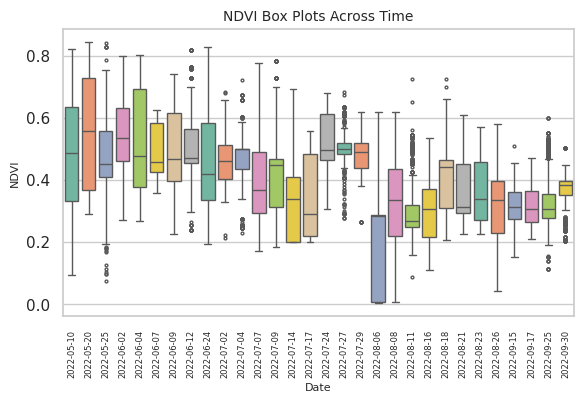

<ipython-input-43-ecb337405ecc>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data['date'].dt.date, y=data['pm25'], palette=common_palette, fliersize=circle_size)


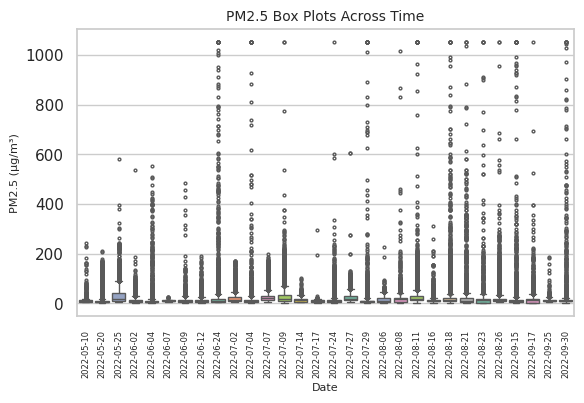

<ipython-input-43-ecb337405ecc>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data['date'].dt.date, y=data['no2'], palette=common_palette, fliersize=circle_size)


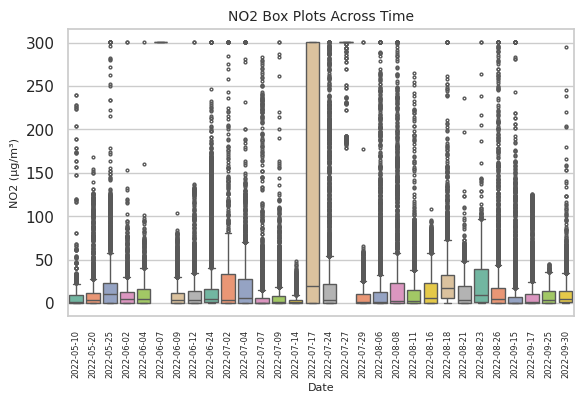

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset (assuming it has 'date', 'NDVI', 'PM2.5', and 'NO2' columns)
data = pd.read_csv('/content/Mozambique_filtered_dates_with_combined_ndvi.csv')

# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Drop duplicates and rows with missing values in NDVI, PM2.5, or NO2
data.drop_duplicates(inplace=True)
data.dropna(subset=['NDVI', 'pm25', 'no2'], inplace=True)

# Common settings for box plot appearance
common_palette = 'Set2'
circle_size = 2  # Reduce the size of the circles for outliers

# Reduced figure size for journal compatibility
fig_width = 6  # Set width smaller for journal publication
fig_height = 4  # Set height smaller for journal publication

# Box plots for NDVI over time
plt.figure(figsize=(fig_width, fig_height))
sns.boxplot(x=data['date'].dt.date, y=data['NDVI'], palette=common_palette, fliersize=circle_size)
plt.xticks(rotation=90, fontsize=6)  # Reduced font size for x-axis labels
plt.ylabel('NDVI', fontsize=8)  # Reduced font size for y-axis label
plt.xlabel('Date', fontsize=8)  # Reduced font size for x-axis label
plt.tight_layout()
plt.title('NDVI Box Plots Across Time', fontsize=10)  # Smaller title font
plt.show()

# Box plots for PM2.5 over time
plt.figure(figsize=(fig_width, fig_height))
sns.boxplot(x=data['date'].dt.date, y=data['pm25'], palette=common_palette, fliersize=circle_size)
plt.xticks(rotation=90, fontsize=6)  # Reduced font size for x-axis labels
plt.ylabel('PM2.5 (µg/m³)', fontsize=8)  # Reduced font size for y-axis label
plt.xlabel('Date', fontsize=8)  # Reduced font size for x-axis label
plt.tight_layout()
plt.title('PM2.5 Box Plots Across Time', fontsize=10)  # Smaller title font
plt.show()

# Box plots for NO2 over time
plt.figure(figsize=(fig_width, fig_height))
sns.boxplot(x=data['date'].dt.date, y=data['no2'], palette=common_palette, fliersize=circle_size)
plt.xticks(rotation=90, fontsize=6)  # Reduced font size for x-axis labels
plt.ylabel('NO2 (µg/m³)', fontsize=8)  # Reduced font size for y-axis label
plt.xlabel('Date', fontsize=8)  # Reduced font size for x-axis label
plt.tight_layout()
plt.title('NO2 Box Plots Across Time', fontsize=10)  # Smaller title font
plt.show()


<ipython-input-44-1a794209e9e8>:6: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/Mozambique_filtered_dates_with_combined_ndvi.csv')
<ipython-input-44-1a794209e9e8>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='date_str', y='NDVI', data=data, palette='Blues')
<ipython-input-44-1a794209e9e8>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='date_str', y='pm25', data=data, palette='Reds')
<ipython-input-44-1a794209e9e8>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the sa

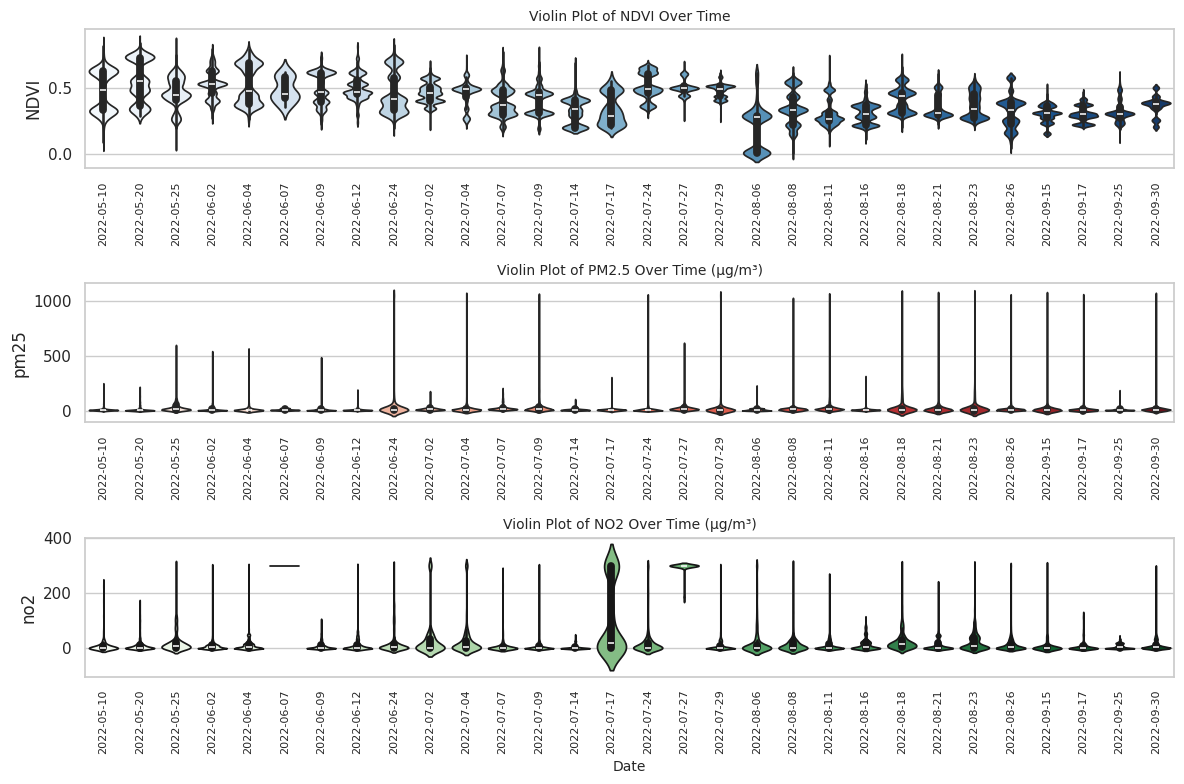

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset (assuming it has 'date', 'NDVI', 'PM2.5', and 'NO2' columns)
data = pd.read_csv('/content/Mozambique_filtered_dates_with_combined_ndvi.csv')

# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Create a new column 'date_str' to show dates as strings for better plotting
data['date_str'] = data['date'].dt.strftime('%Y-%m-%d')

# Drop duplicates and rows with missing values in NDVI, PM2.5, or NO2
data.drop_duplicates(inplace=True)
data.dropna(subset=['NDVI', 'pm25', 'no2'], inplace=True)

# Set the plot style
sns.set(style="whitegrid")

# Create violin plots
plt.figure(figsize=(12, 8))

# Violin plot for NDVI
plt.subplot(3, 1, 1)
sns.violinplot(x='date_str', y='NDVI', data=data, palette='Blues')
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('')
plt.title('Violin Plot of NDVI Over Time', fontsize=10)

# Violin plot for PM2.5
plt.subplot(3, 1, 2)
sns.violinplot(x='date_str', y='pm25', data=data, palette='Reds')
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('')
plt.title('Violin Plot of PM2.5 Over Time (µg/m³)', fontsize=10)

# Violin plot for NO2
plt.subplot(3, 1, 3)
sns.violinplot(x='date_str', y='no2', data=data, palette='Greens')
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Date', fontsize=10)
plt.title('Violin Plot of NO2 Over Time (µg/m³)', fontsize=10)

# Adjust layout for better fit
plt.tight_layout()
plt.show()


<ipython-input-45-d66110981993>:8: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/Mozambique_filtered_dates_with_combined_ndvi.csv')
<ipython-input-45-d66110981993>:33: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

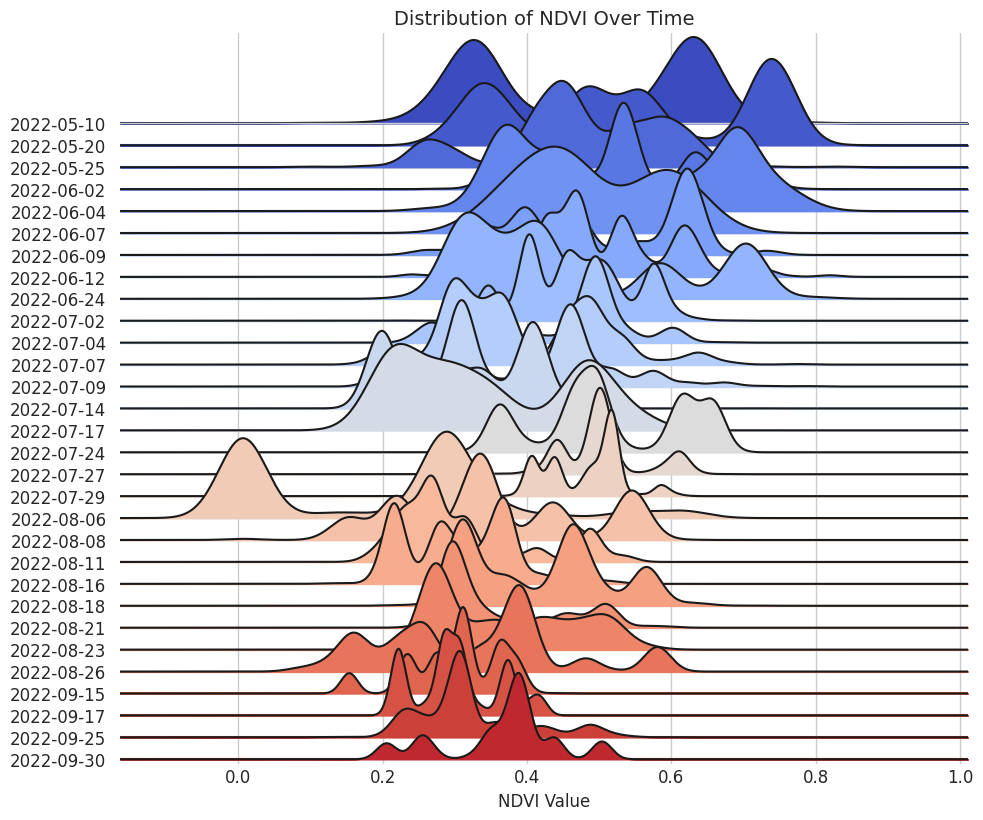

<ipython-input-45-d66110981993>:33: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

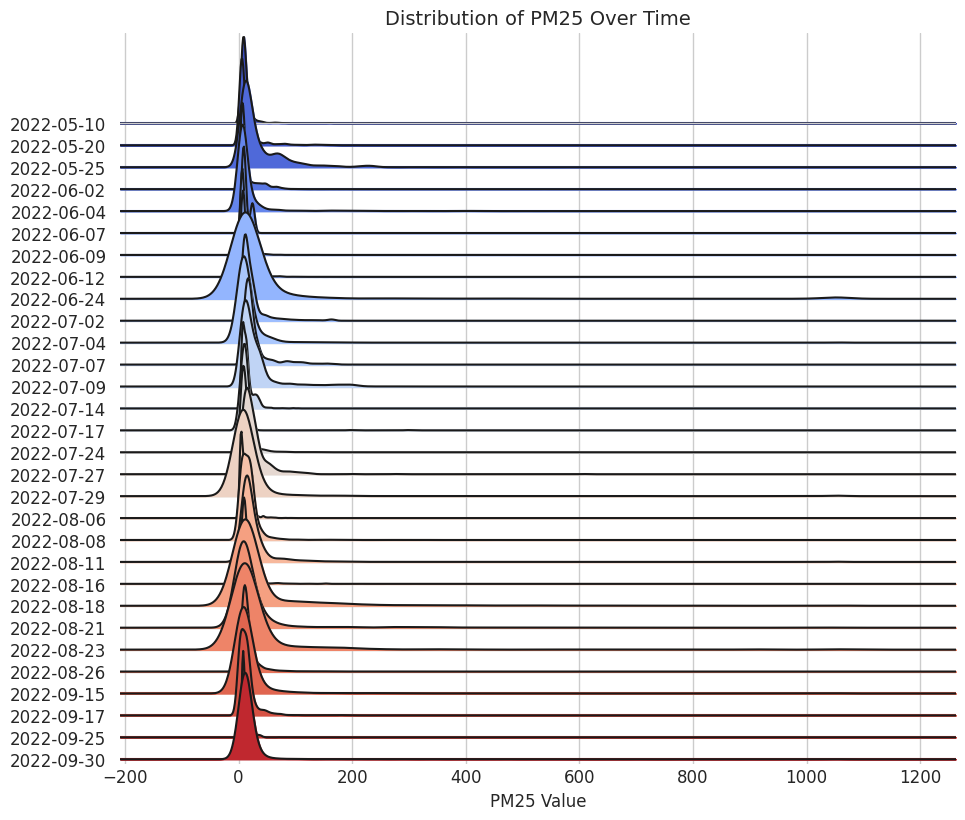

<ipython-input-45-d66110981993>:33: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

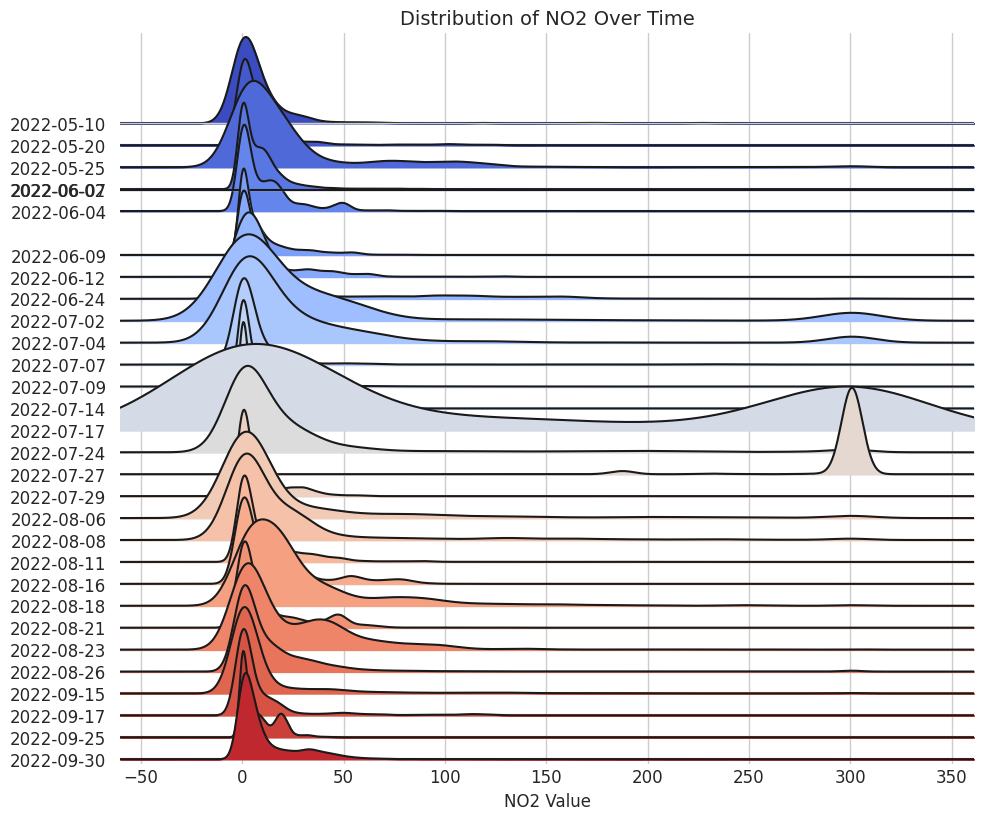

In [45]:
!pip install joypy
import pandas as pd
import matplotlib.pyplot as plt
import joypy
from matplotlib import cm

# Load the dataset (assuming it has 'date', 'NDVI', 'PM2.5', and 'NO2' columns)
data = pd.read_csv('/content/Mozambique_filtered_dates_with_combined_ndvi.csv')

# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Remove missing values
data.dropna(subset=['NDVI', 'pm25', 'no2'], inplace=True)

# Select specific columns for the plot
columns_to_plot = ['NDVI', 'pm25', 'no2']

# Create a subplot for each of the columns (NDVI, PM2.5, and NO2)
for column in columns_to_plot:
    plt.figure(figsize=(12, 8))

    # Create the joypy plot
    joypy.joyplot(data, by=data['date'].dt.date, column=[column], ylim='own',
                  colormap=cm.coolwarm, figsize=(10, 8), grid=True)

    # Add labels and title
    plt.title(f'Distribution of {column.upper()} Over Time', fontsize=14)
    plt.xlabel(f'{column.upper()} Value', fontsize=12)
    plt.ylabel('Date', fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()


In [ ]:
!pip install seaborn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset (assuming it has 'date', 'NDVI', 'PM2.5', and 'NO2' columns)
data = pd.read_csv('/content/Mozambique_filtered_dates_with_combined_ndvi.csv')

# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Drop duplicates and rows with missing values in NDVI, PM2.5, or NO2
data.drop_duplicates(inplace=True)
data.dropna(subset=['NDVI', 'pm25', 'no2'], inplace=True)

# Create a swarm plot for each variable (NDVI, PM2.5, NO2) over time
variables = ['NDVI', 'pm25', 'no2']

# Create a swarm plot for each variable with time as the x-axis
for variable in variables:
    plt.figure(figsize=(10, 6))

    # Create the swarm plot
    sns.swarmplot(x='date', y=variable, data=data, color='b', size=3)

    # Add labels and title
    plt.xlabel('Date', fontsize=10)
    plt.ylabel(f'{variable.upper()} Value', fontsize=10)
    plt.title(f'Swarm Plot for {variable.upper()} Over Time', fontsize=12)

    # Rotate x-ticks to avoid overlap
    plt.xticks(rotation=45, fontsize=8)

    # Adjust layout for better fitting
    plt.tight_layout()

    # Show the plot
    plt.show()


<ipython-input-46-954568164561>:7: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/Mozambique_filtered_dates_with_combined_ndvi.csv')


<ipython-input-39-90a79f113f4f>:7: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/Mozambique_filtered_dates_with_combined_ndvi.csv')  # Replace with actual path


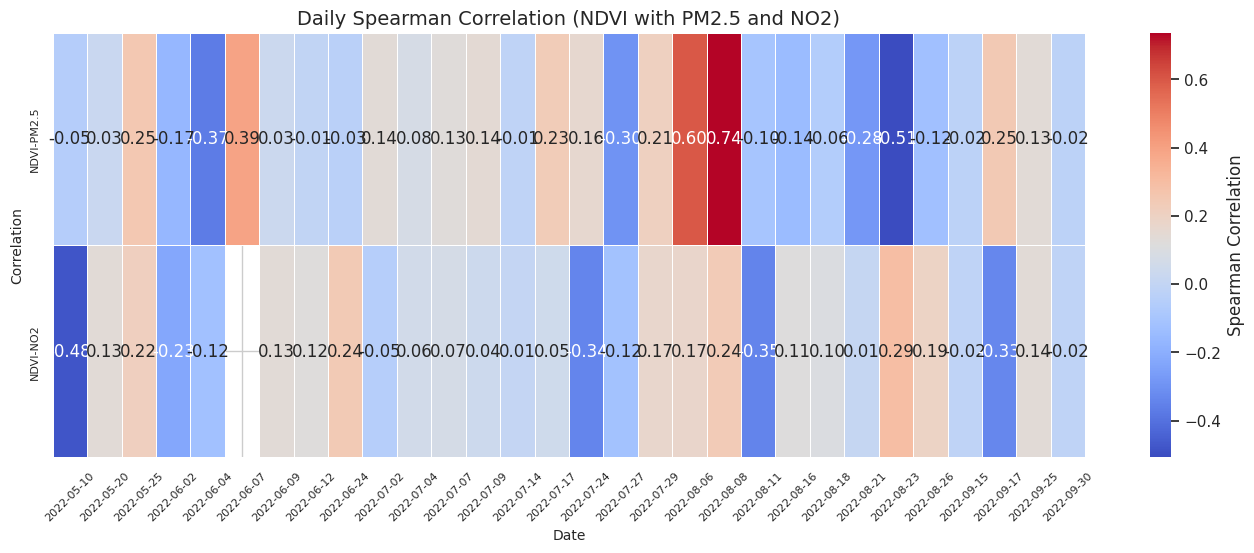

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
data = pd.read_csv('/content/Mozambique_filtered_dates_with_combined_ndvi.csv')  # Replace with actual path

# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Drop duplicates and rows with missing values in NDVI, PM2.5, or NO2
data.drop_duplicates(inplace=True)
data.dropna(subset=['NDVI', 'pm25', 'no2'], inplace=True)

# Group the data by date and calculate daily correlations (Spearman)
daily_correlations = []
for date, group in data.groupby(data['date'].dt.date):
    corr = group[['NDVI', 'pm25', 'no2']].corr(method='spearman')
    daily_correlations.append(corr.values.flatten())

# Convert the list of correlations to a DataFrame
daily_corr_df = pd.DataFrame(daily_correlations, columns=['NDVI-NDVI', 'NDVI-PM2.5', 'NDVI-NO2',
                                                          'PM2.5-NDVI', 'PM2.5-PM2.5', 'PM2.5-NO2',
                                                          'NO2-NDVI', 'NO2-PM2.5', 'NO2-NO2'])
daily_corr_df['date'] = data['date'].dt.date.unique()

# Create a heatmap of NDVI correlations with PM2.5 and NO2 over time
plt.figure(figsize=(14, 6))  # Adjust figure size to increase width

# Create the heatmap for NDVI vs PM2.5 and NDVI vs NO2
sns.heatmap(daily_corr_df[['NDVI-PM2.5', 'NDVI-NO2']].T, cmap='coolwarm', annot=True, fmt=".2f",
            xticklabels=daily_corr_df['date'], cbar_kws={'label': 'Spearman Correlation'},
            linewidths=0.5)  # Increase the bar width slightly by adding linewidths

# Set labels and title with smaller fonts
plt.title('Daily Spearman Correlation (NDVI with PM2.5 and NO2)', fontsize=14)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Correlation', fontsize=10)
plt.xticks(rotation=45, fontsize=8)  # Reduce font size for x-axis labels
plt.yticks(fontsize=8)  # Reduce font size for y-axis labels

# Adjust the layout and reduce color bar length
plt.tight_layout(pad=2)  # Adjust padding to make it fit nicely
plt.show()


<ipython-input-21-2a18cf689ad3>:3: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/dynamic_indicators/Mozambique_filtered_dates_with_combined_ndvi.csv')


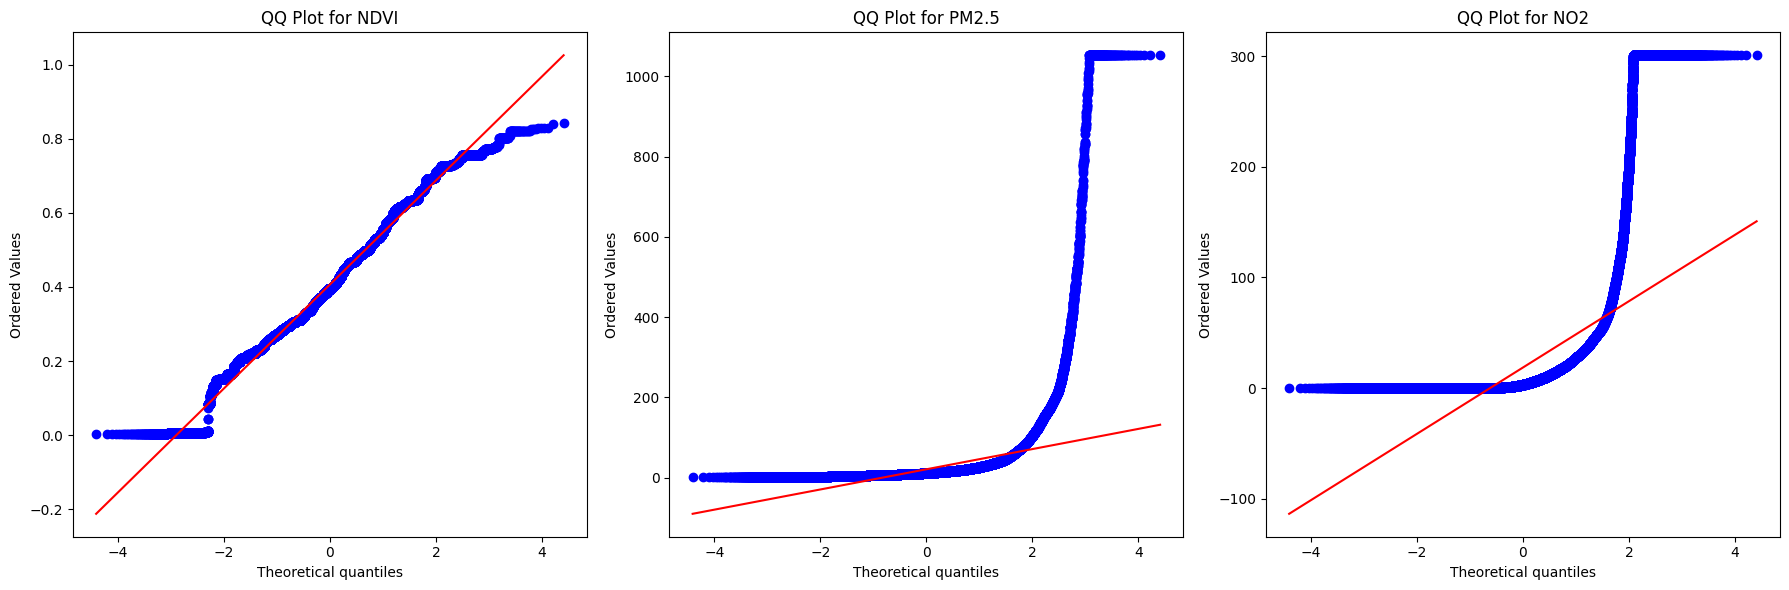

In [ ]:
##QQ-Plots for NDVI ,NO2 and PM2.5
# Load the dataset (assuming it has 'NDVI', 'PM2.5', and 'NO2' columns)
data = pd.read_csv('/content/dynamic_indicators/Mozambique_filtered_dates_with_combined_ndvi.csv')

# Drop any rows with missing values in NDVI, PM2.5, or NO2
data = data.dropna(subset=['NDVI', 'pm25', 'no2'])

# Create QQ plots
plt.figure(figsize=(18, 6))

# QQ plot for NDVI
plt.subplot(1, 3, 1)
stats.probplot(data['NDVI'], dist="norm", plot=plt)
plt.title('QQ Plot for NDVI')

# QQ plot for PM2.5
plt.subplot(1, 3, 2)
stats.probplot(data['pm25'], dist="norm", plot=plt)
plt.title('QQ Plot for PM2.5')

# QQ plot for NO2
plt.subplot(1, 3, 3)
stats.probplot(data['no2'], dist="norm", plot=plt)
plt.title('QQ Plot for NO2')

# Display the plots
plt.tight_layout()
plt.show()


<ipython-input-27-8470ae803c77>:3: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/dynamic_indicators/Mozambique_filtered_dates_with_combined_ndvi.csv')


Kolmogorov-Smirnov Test Results:
NDVI: KS Statistic = 0.0490, P-value = 0.0000
PM2.5: KS Statistic = 0.3543, P-value = 0.0000
NO2: KS Statistic = 0.3476, P-value = 0.0000


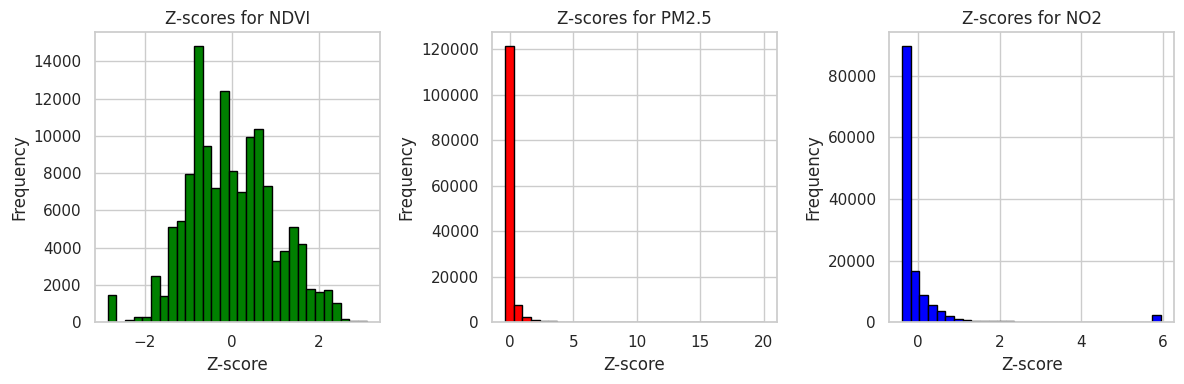

In [ ]:
##Perfom Normality test using Kolmogrov Smirnov test
# Load the dataset (assuming it has 'NDVI', 'PM2.5', and 'NO2' columns)
data = pd.read_csv('/content/dynamic_indicators/Mozambique_filtered_dates_with_combined_ndvi.csv')

# Drop any rows with missing values in NDVI, PM2.5, or NO2
data = data.dropna(subset=['NDVI', 'pm25', 'no2'])

# Kolmogorov-Smirnov test for normality
ks_stat_ndvi, p_value_ndvi = stats.kstest(data['NDVI'], 'norm', args=(data['NDVI'].mean(), data['NDVI'].std()))
ks_stat_pm25, p_value_pm25 = stats.kstest(data['pm25'], 'norm', args=(data['pm25'].mean(), data['pm25'].std()))
ks_stat_no2, p_value_no2 = stats.kstest(data['no2'], 'norm', args=(data['no2'].mean(), data['no2'].std()))

# Print K-S test results
print("Kolmogorov-Smirnov Test Results:")
print(f"NDVI: KS Statistic = {ks_stat_ndvi:.4f}, P-value = {p_value_ndvi:.4f}")
print(f"PM2.5: KS Statistic = {ks_stat_pm25:.4f}, P-value = {p_value_pm25:.4f}")
print(f"NO2: KS Statistic = {ks_stat_no2:.4f}, P-value = {p_value_no2:.4f}")

# Calculate Z-scores for NDVI, PM2.5, and NO2
data['NDVI_z'] = (data['NDVI'] - data['NDVI'].mean()) / data['NDVI'].std()
data['pm25_z'] = (data['pm25'] - data['pm25'].mean()) / data['pm25'].std()
data['no2_z'] = (data['no2'] - data['no2'].mean()) / data['no2'].std()

# Plot the Z-scores
plt.figure(figsize=(12,4))

# Z-scores for NDVI
plt.subplot(1, 3, 1)
plt.hist(data['NDVI_z'], bins=30, color='green', edgecolor='black')
plt.title('Z-scores for NDVI')
plt.xlabel('Z-score')
plt.ylabel('Frequency')

# Z-scores for PM2.5
plt.subplot(1, 3, 2)
plt.hist(data['pm25_z'], bins=30, color='red', edgecolor='black')
plt.title('Z-scores for PM2.5')
plt.xlabel('Z-score')
plt.ylabel('Frequency')

# Z-scores for NO2
plt.subplot(1, 3, 3)
plt.hist(data['no2_z'], bins=30, color='blue', edgecolor='black')
plt.title('Z-scores for NO2')
plt.xlabel('Z-score')
plt.ylabel('Frequency')

# Display the plot
plt.tight_layout()
plt.show()


<ipython-input-21-c6aeaf94825a>:6: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/Mozambique_filtered_dates_with_combined_ndvi.csv')


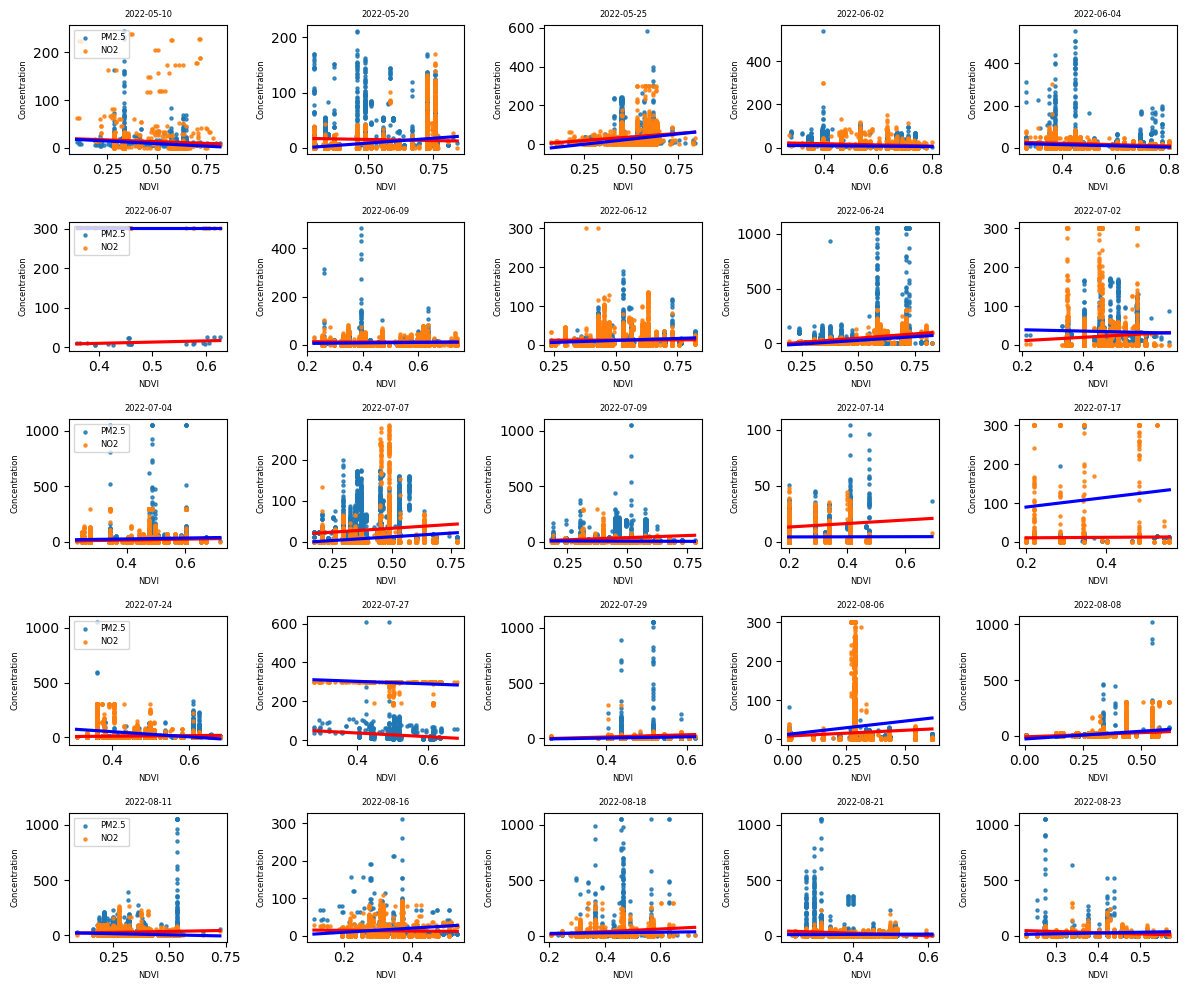

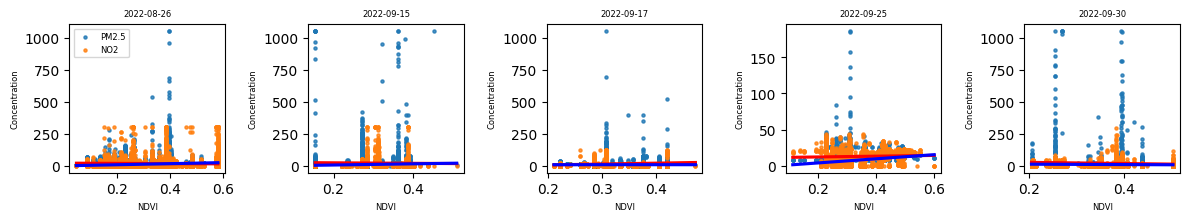

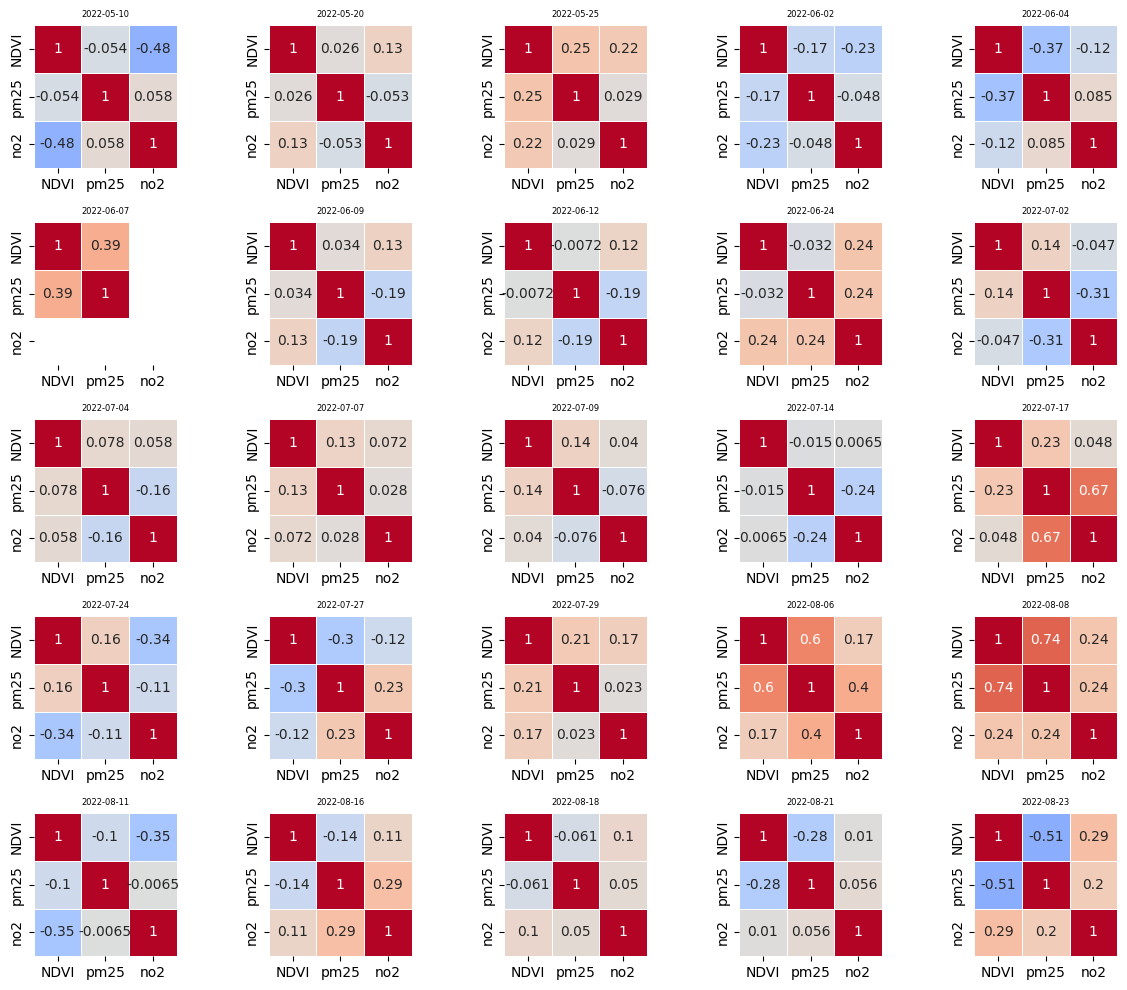

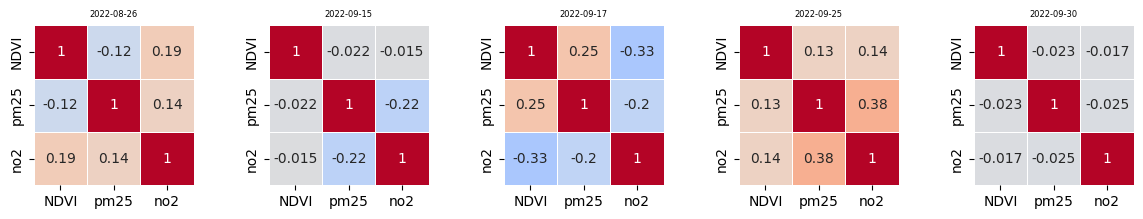

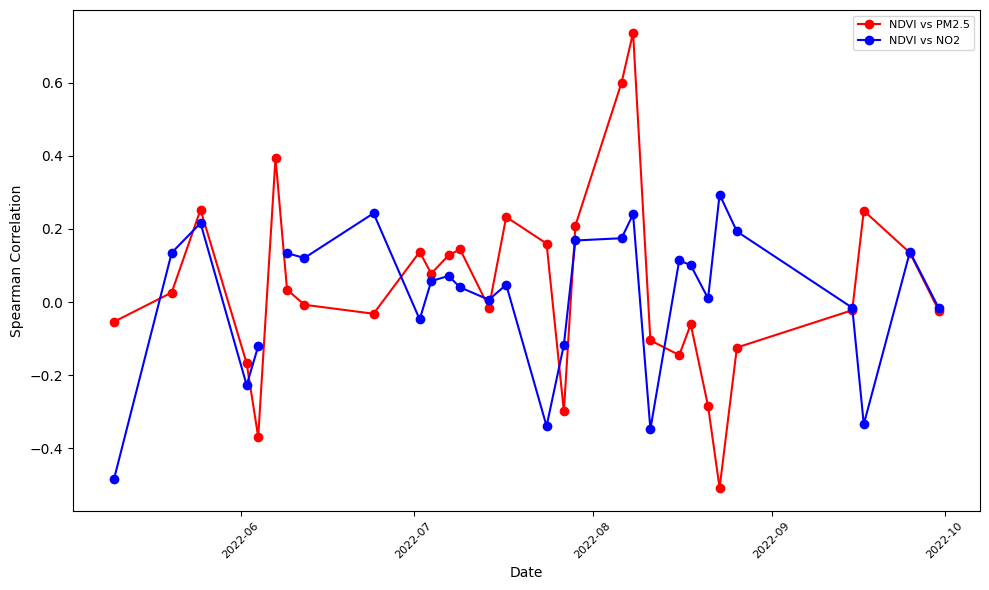

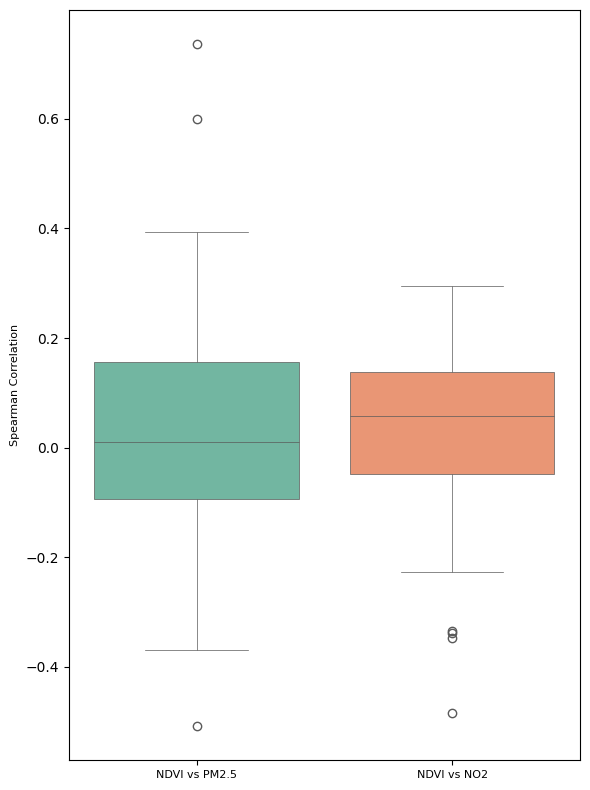

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset (assuming it has 'date', 'NDVI', 'PM2.5', and 'NO2' columns)
data = pd.read_csv('/content/Mozambique_filtered_dates_with_combined_ndvi.csv')

# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Drop duplicates and rows with missing values in NDVI, PM2.5, or NO2
data.drop_duplicates(inplace=True)
data.dropna(subset=['NDVI', 'pm25', 'no2'], inplace=True)

# Unique dates in the data
unique_dates = data['date'].dt.date.unique()

# Define the maximum number of plots per figure (5x5 grid)
max_plots_per_page = 25

# List to store correlation results for each date
correlation_results = []

# Function to plot scatter plots with legends per row
def plot_scatter_plots_with_legend(data, unique_dates, max_plots_per_page):
    # Loop through each unique date and split into multiple pages if needed
    for page_num in range(0, len(unique_dates), max_plots_per_page):
        plt.figure(figsize=(12, 10))

        # Process a chunk of up to 25 dates per page
        chunk_dates = unique_dates[page_num:page_num + max_plots_per_page]

        for i, date in enumerate(chunk_dates):
            # Filter data for the current date
            daily_data = data[data['date'].dt.date == date]

            if len(daily_data) >= 2:  # Check if there's enough data for scatter plots
                plt.subplot(5, 5, i + 1)

                # Plot scatter plot with trend line for NDVI vs PM2.5
                sns.regplot(x=daily_data['NDVI'], y=daily_data['pm25'], ci=None, scatter_kws={'s': 5}, line_kws={'color': 'red'}, label='PM2.5')

                # Plot scatter plot with trend line for NDVI vs NO2
                sns.regplot(x=daily_data['NDVI'], y=daily_data['no2'], ci=None, scatter_kws={'s': 5}, line_kws={'color': 'blue'}, label='NO2')

                # Add date as the title with smaller font size
                plt.title(f'{date}', fontsize=6)
                plt.xlabel('NDVI', fontsize=6)
                plt.ylabel('Concentration', fontsize=6)

                # Add legend only once per row
                if i % 5 == 0:  # Only on the first plot in each row
                    plt.legend(loc='upper left', fontsize=6)

        # Adjust the layout to make sure plots fit well
        plt.tight_layout()
        plt.show()

# Call the function to plot scatter plots with legends per row
plot_scatter_plots_with_legend(data, unique_dates, max_plots_per_page)

# Function to plot correlation heatmap and scatter plots
def plot_correlation_and_scatter(data, unique_dates, max_plots_per_page):
    # Loop through each unique date and split into multiple pages if needed
    for page_num in range(0, len(unique_dates), max_plots_per_page):
        plt.figure(figsize=(12, 10))

        # Process a chunk of up to 25 dates per page
        chunk_dates = unique_dates[page_num:page_num + max_plots_per_page]

        for i, date in enumerate(chunk_dates):
            # Filter data for the current date
            daily_data = data[data['date'].dt.date == date]

            if len(daily_data) >= 2:  # Check if there's enough data for correlation
                # Calculate Spearman correlation for the current date
                spearman_corr = daily_data[['NDVI', 'pm25', 'no2']].corr(method='spearman')

                # Append results to the list
                correlation_results.append({
                    'date': date,
                    'spearman_corr_ndvi_pm25': spearman_corr.loc['NDVI', 'pm25'],
                    'spearman_corr_ndvi_no2': spearman_corr.loc['NDVI', 'no2']
                })

                # Create a subplot for each date's correlation heatmap and scatter plots
                plt.subplot(5, 5, i + 1)

                # Create a heatmap of the Spearman correlations for each date
                sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', cbar=False, square=True, vmin=-1, vmax=1, linewidths=0.5)

                # Add date as the title with smaller font size
                plt.title(f'{date}', fontsize=6)

        # Adjust the layout to make sure plots fit well
        plt.tight_layout()
        plt.show()

# Call the function to plot correlations and scatter plots
plot_correlation_and_scatter(data, unique_dates, max_plots_per_page)

# Convert correlation results into a DataFrame
correlation_df = pd.DataFrame(correlation_results)

# Plot the trend of daily correlations
def plot_daily_correlation_trend(correlation_df):
    plt.figure(figsize=(10, 6))

    # Plot the trend for NDVI vs PM2.5
    plt.plot(correlation_df['date'], correlation_df['spearman_corr_ndvi_pm25'], label='NDVI vs PM2.5', color='red', marker='o')

    # Plot the trend for NDVI vs NO2
    plt.plot(correlation_df['date'], correlation_df['spearman_corr_ndvi_no2'], label='NDVI vs NO2', color='blue', marker='o')

    # Add labels and title
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Spearman Correlation', fontsize=10)
    plt.xticks(rotation=45, fontsize=8)
    plt.legend(loc='upper right', fontsize=8)

    # Display the plot
    plt.tight_layout()
    plt.show()

# Call the function to plot the daily correlation trend
plot_daily_correlation_trend(correlation_df)

# Function to create combined box plots of correlations
def plot_combined_correlation_boxplots(correlation_df):
    plt.figure(figsize=(6, 8))
    sns.boxplot(data=correlation_df[['spearman_corr_ndvi_pm25', 'spearman_corr_ndvi_no2']], palette="Set2", linewidth=0.5)

    # Reduce label font sizes
    plt.ylabel('Spearman Correlation', fontsize=8)
    plt.xticks(ticks=[0, 1], labels=['NDVI vs PM2.5', 'NDVI vs NO2'], fontsize=8)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Call the combined box plot function
plot_combined_correlation_boxplots(correlation_df)

# Save correlation results to a CSV file if needed
correlation_df.to_csv('/content/date_wise_correlations.csv', index=False)
